# Package Delivery Optimization System
### Authors: Anran Lyu, Xinghang Tong, Shixing Mao

In [ ]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 1.8 MB/s eta 0:00:00


In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import random
import folium
from folium.plugins import MarkerCluster
from itertools import combinations
import time
import heapq
from collections import defaultdict, deque
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Set random seed to ensure reproducibility
np.random.seed(42)
random.seed(42)


## 1. Data Generation


### 1.1 Get Road Network from OpenStreetMap

In [ ]:
def get_road_network(place_name, network_type='drive'):
    """
    Get road network for a specific location from OpenStreetMap

    Parameters:
        place_name (str): Name of the place, e.g., "Brooklyn Heights, Brooklyn, New York City, New York, USA"
        network_type (str): Type of network, e.g., 'drive', 'bike', 'walk', etc.

    Returns:
        G (networkx.MultiDiGraph): Road network graph
        gdf_nodes (GeoDataFrame): Graph nodes
        gdf_edges (GeoDataFrame): Graph edges
    """
    print(f"Downloading road network for {place_name}...")

    # Get road network from OpenStreetMap
    G = ox.graph_from_place(place_name, network_type=network_type)

    # Store original geographic coordinates before projection
    for node, data in G.nodes(data=True):
        data['lon'] = data['x']  # 经度
        data['lat'] = data['y']  # 纬度

    # Project graph to a projected coordinate system for accurate distance calculation
    G = ox.project_graph(G)

    # Convert to undirected graph as we assume roads are bidirectional
    G = G.to_undirected()

    # Calculate edge weights (using length as weight)
    for u, v, data in G.edges(data=True):
        if 'length' in data:
            data['weight'] = data['length']
        else:
            data['weight'] = 1.0

    # Get GeoDataFrames for nodes and edges
    gdf_nodes = ox.graph_to_gdfs(G, edges=False)
    gdf_edges = ox.graph_to_gdfs(G, nodes=False)

    print(f"Successfully downloaded road network with {len(G.nodes)} nodes and {len(G.edges)} edges")

    return G, gdf_nodes, gdf_edges

### 1.2 Generate Synthetic Package Data

In [ ]:
def generate_package_data(G, num_packages=50, depot_node=None):
    """
    Generate synthetic package data

    Parameters:
        G (networkx.MultiDiGraph): Road network graph
        num_packages (int): Number of packages to generate
        depot_node (int): Depot node ID, if None a random node will be selected

    Returns:
        packages_df (pandas.DataFrame): DataFrame containing package data
        depot_node (int): Depot node ID
    """
    print(f"Generating {num_packages} synthetic packages...")

    # Get list of graph nodes
    nodes = list(G.nodes())

    # If depot node is not specified, randomly select one
    if depot_node is None:
        depot_node = random.choice(nodes)

    # Get depot coordinates - use geographic coordinates
    depot_coords = (G.nodes[depot_node]['lat'], G.nodes[depot_node]['lon'])

    # Generate package data
    packages = []
    for i in range(num_packages):
        # Randomly select a destination node (different from depot)
        destination_node = random.choice([n for n in nodes if n != depot_node])
        destination_coords = (G.nodes[destination_node]['lat'], G.nodes[destination_node]['lon'])

        # Generate package weight (1-20 kg)
        weight = round(random.uniform(1, 20), 2)

        # Generate package volume (0.001-0.03 cubic meters)
        volume = round(random.uniform(0.001, 0.03), 4)

        packages.append({
            'Package_ID': f'P{i+1:03d}',
            'Destination_Node': destination_node,
            'Destination_Lat': destination_coords[0],
            'Destination_Lon': destination_coords[1],
            'Weight': weight,
            'Volume': volume
        })

    # Create DataFrame
    packages_df = pd.DataFrame(packages)

    print(f"Successfully generated {num_packages} packages")
    print(f"Depot location: Node ID={depot_node}, Coordinates=({depot_coords[0]:.6f}, {depot_coords[1]:.6f})")

    return packages_df, depot_node

### 1.3 Visualize Data

In [ ]:
def plot_road_network_with_packages(G, packages_df, depot_node):
    """
    Visualize road network and package locations

    Parameters:
        G (networkx.MultiDiGraph): Road network graph
        packages_df (pandas.DataFrame): DataFrame containing package data
        depot_node (int): Depot node ID
    """
    print("Generating map visualization...")

    # Get bounding box of the graph
    bbox = ox.utils_geo.bbox_from_point(
        (G.nodes[list(G.nodes())[0]]['lat'], G.nodes[list(G.nodes())[0]]['lon']),
        dist=2000
    )

    # Create map
    depot_coords = (G.nodes[depot_node]['lat'], G.nodes[depot_node]['lon'])
    m = folium.Map(location=depot_coords, zoom_start=15)

    # Use OpenStreetMap tiles for better performance
    folium.TileLayer('openstreetmap').add_to(m)

    # Add package locations
    marker_cluster = MarkerCluster().add_to(m)

    for _, package in packages_df.iterrows():
        folium.Marker(
            location=(package['Destination_Lat'], package['Destination_Lon']),
            popup=f"Package ID: {package['Package_ID']}<br>"
                  f"Weight: {package['Weight']} kg<br>"
                  f"Volume: {package['Volume']} m³",
            icon=folium.Icon(color='blue', icon='cube', prefix='fa')
        ).add_to(marker_cluster)

    # Add depot location
    folium.Marker(
        location=depot_coords,
        popup="Depot",
        icon=folium.Icon(color='red', icon='warehouse', prefix='fa')
    ).add_to(m)

    return m

## 2. Graph Building and Shortest Path Algorithms

In [ ]:
def build_distance_matrix(G, packages_df, depot_node):
    """
    Build distance matrix between all package points and depot

    Parameters:
        G (networkx.MultiDiGraph): Road network graph
        packages_df (pandas.DataFrame): DataFrame containing package data
        depot_node (int): Depot node ID

    Returns:
        dist_matrix (numpy.ndarray): Distance matrix
        locations (list): List of locations including depot and all package points
    """
    print("Building distance matrix...")

    # Get all package destination nodes
    package_nodes = packages_df['Destination_Node'].unique().tolist()

    # Add depot node to the list of locations
    locations = [depot_node] + package_nodes

    # Initialize distance matrix
    n = len(locations)
    dist_matrix = np.zeros((n, n))

    # Calculate shortest path distance between each pair of locations
    for i in range(n):
        for j in range(i+1, n):
            if i != j:
                try:
                    # Use Dijkstra's algorithm to calculate shortest path distance
                    dist = nx.shortest_path_length(G,
                                                  source=locations[i],
                                                  target=locations[j],
                                                  weight='weight')
                    dist_matrix[i, j] = dist
                    dist_matrix[j, i] = dist  # Symmetric matrix
                except nx.NetworkXNoPath:
                    # If no path exists, set a large value
                    dist_matrix[i, j] = float('inf')
                    dist_matrix[j, i] = float('inf')

    print("Distance matrix built successfully")

    return dist_matrix, locations

## 3. Knapsack Dynamic Programming Algorithm

In [ ]:
def knapsack_dp(packages_df, weight_capacity, volume_capacity):
    """
    Solve the 2D knapsack problem using dynamic programming.

    Parameters:
        packages_df (pandas.DataFrame): Package data
        weight_capacity (float): Max weight in kg
        volume_capacity (float): Max volume in m³

    Returns:
        selected_packages (list): List of selected indices
        total_weight (float)
        total_volume (float)
    """
    print("Running knapsack algorithm to optimize loading...")

    n = len(packages_df)
    if n == 0:
        return [], 0, 0

    # Use reasonable precision: 0.1 kg and 1L
    weight_precision = 10      # 0.1 kg = 100g
    volume_precision = 1000    # 0.001 m³ = 1L

    W = int(weight_capacity * weight_precision)
    V = int(volume_capacity * volume_precision)

    weights = [int(packages_df.iloc[i]['Weight'] * weight_precision) for i in range(n)]
    volumes = [int(packages_df.iloc[i]['Volume'] * volume_precision) for i in range(n)]

    print(f"📦 Package 0 example — Weight: {weights[0]}, Volume: {volumes[0]}")
    print(f"🚛 Knapsack capacity in DP units — W: {W}, V: {V}")

    # Initialize DP
    dp = {(0, 0): 0}
    chosen = {(0, 0): []}

    for i in range(n):
        weight_i = weights[i]
        volume_i = volumes[i]

        current_states = list(dp.items())

        for (curr_weight, curr_volume), curr_value in current_states:
            new_weight = curr_weight + weight_i
            new_volume = curr_volume + volume_i

            if new_weight <= W and new_volume <= V:
                new_state = (new_weight, new_volume)
                new_value = curr_value + 1

                if new_state not in dp or new_value > dp[new_state]:
                    dp[new_state] = new_value
                    chosen[new_state] = chosen[(curr_weight, curr_volume)] + [i]

                    # if len(dp) < 5:  # Show a few states
                    #     print(f"✅ Added state: {new_state} with {new_value} packages")

    # Find best result
    best_state = max(dp, key=lambda s: dp[s])
    selected_packages = chosen[best_state]
    total_weight = best_state[0] / weight_precision
    total_volume = best_state[1] / volume_precision

    if not selected_packages:
        print("⚠️ No feasible combination found under capacity limits.")

    print(f"Knapsack algorithm selected {len(selected_packages)} packages")
    print(f"Total weight: {total_weight:.2f} kg / {weight_capacity} kg")
    print(f"Total volume: {total_volume:.4f} m³ / {volume_capacity} m³")

    return selected_packages, total_weight, total_volume


## 4. Traveling Salesman Problem (TSP) using Dynamic Programming

In [ ]:
def tsp_dp(dist_matrix, selected_indices, depot_index=0):
    """
    Optimal TSP solver using Held-Karp dynamic programming algorithm.

    Args:
        dist_matrix (np.ndarray): Full distance matrix.
        selected_indices (List[int]): Package indices to visit (indices into dist_matrix).
        depot_index (int): Depot index in dist_matrix.

    Returns:
        Tuple[List[int], float]: Optimal route (indices into dist_matrix), total distance.
    """
    from itertools import combinations
    import math

    # All nodes to visit including depot
    nodes = [depot_index] + list(set(selected_indices))
    n = len(nodes)
    node_to_index = {node: i for i, node in enumerate(nodes)}
    index_to_node = {i: node for i, node in enumerate(nodes)}

    # Distance submatrix for selected nodes
    submatrix = [[dist_matrix[index_to_node[i]][index_to_node[j]] for j in range(n)] for i in range(n)]

    # DP table: dp[subset][last] = min cost to reach `last` via `subset`
    dp = {}
    parent = {}

    # Initialize base case (paths from depot)
    for k in range(1, n):
        dp[(1 << k, k)] = submatrix[0][k]
        parent[(1 << k, k)] = 0

    # Fill DP table
    for subset_size in range(2, n):
        for subset in combinations(range(1, n), subset_size):
            bits = sum(1 << k for k in subset)
            for k in subset:
                prev_bits = bits & ~(1 << k)
                best_cost = math.inf
                best_prev = None
                for m in subset:
                    if m == k:
                        continue
                    if (prev_bits, m) in dp:
                        cost = dp[(prev_bits, m)] + submatrix[m][k]
                        if cost < best_cost:
                            best_cost = cost
                            best_prev = m
                dp[(bits, k)] = best_cost
                parent[(bits, k)] = best_prev

    # Close the loop: return to depot
    bits = (1 << n) - 2  # all bits except depot
    best_cost = math.inf
    last = None
    for k in range(1, n):
        cost = dp[(bits, k)] + submatrix[k][0]
        if cost < best_cost:
            best_cost = cost
            last = k

    # Reconstruct path
    path = [0]
    bitmask = bits
    while last is not None:
        path.append(last)
        temp = parent.get((bitmask, last))
        bitmask &= ~(1 << last)
        last = temp

    path = [index_to_node[i] for i in reversed(path)]
    path.append(depot_index)  # Return to depot

    return path, best_cost


def tsp_nearest_neighbor(dist_matrix, selected_indices, depot_index=0):
    """
    Nearest neighbor TSP algorithm using distance matrix indices.

    Args:
        dist_matrix (np.ndarray): Distance matrix.
        selected_indices (List[int]): Indices into the matrix (not graph node IDs).
        depot_index (int): Index of the depot in the matrix.

    Returns:
        Tuple[List[int], float]: Route (indices into dist_matrix), total distance.
    """
    print(f"Running nearest neighbor TSP with {len(selected_indices)} packages")

    selected_indices = list(set(selected_indices))
    if not selected_indices:
        return [depot_index, depot_index], 0

    matrix_size = dist_matrix.shape[0]
    valid_indices = [i for i in selected_indices if 0 <= i < matrix_size and i != depot_index]

    path = [depot_index]
    unvisited = valid_indices.copy()
    current = depot_index
    total_distance = 0

    while unvisited:
        next_pkg = min(unvisited, key=lambda x: dist_matrix[current][x])
        total_distance += dist_matrix[current][next_pkg]
        path.append(next_pkg)
        current = next_pkg
        unvisited.remove(next_pkg)

    total_distance += dist_matrix[current][depot_index]
    path.append(depot_index)

    return path, total_distance


## 5. Multi-Trip Handling

In [ ]:
def multi_trip_scheduling(packages_df, dist_matrix, locations, depot_node_index, weight_capacity, volume_capacity):
    """
    Schedule multiple trips for package delivery using DP-based knapsack and hybrid TSP.

    Args:
        packages_df (pd.DataFrame): Package info
        dist_matrix (np.ndarray): Full distance matrix
        locations (List[int]): Maps dist_matrix indices to graph node IDs
        depot_node_index (int): Index of depot in dist_matrix
        weight_capacity (float): Max weight per trip
        volume_capacity (float): Max volume per trip

    Returns:
        Tuple[List[Dict], float]: Trips and total distance
    """
    print("🚚 Starting multi-trip scheduling...")

    available_packages = list(range(len(packages_df)))
    trips = []
    total_distance = 0
    max_iterations = 100
    trip_num = 1

    while available_packages and trip_num <= max_iterations:
        print(f"\n📦 Planning trip #{trip_num}...")

        trip_df = packages_df.iloc[available_packages].reset_index(drop=True)
        selected_indices, _, _ = knapsack_dp(trip_df, weight_capacity, volume_capacity)

        if not selected_indices:
            print("⚠️ No packages selected for this trip.")

            oversized = []
            for idx in available_packages:
                pkg = packages_df.iloc[idx]
                if pkg['Weight'] > weight_capacity or pkg['Volume'] > volume_capacity:
                    oversized.append(idx)

            if oversized:
                print(f"⚠️ Skipping {len(oversized)} oversized package(s): {[packages_df.iloc[i]['Package_ID'] for i in oversized]}")
                for idx in oversized:
                    available_packages.remove(idx)
            else:
                print("⚠️ No oversized packages found, but no packages selected. Exiting to avoid infinite loop.")
                break
            continue  # Restart loop after removal

        selected_global_indices = [available_packages[i] for i in selected_indices]

        if len(selected_global_indices) <= 15:
            route, distance = tsp_dp(dist_matrix, selected_global_indices, depot_node_index)
        else:
            print(f"⚠️ {len(selected_global_indices)} packages — using greedy TSP instead.")
            route, distance = tsp_nearest_neighbor(dist_matrix, selected_global_indices, depot_node_index)

        # ✅ Map route to node IDs
        route_node_ids = [locations[i] for i in route]

        trips.append({
            'route': route_node_ids,
            'package_indices': selected_global_indices,
            'distance': distance
        })
        total_distance += distance

        for idx in selected_global_indices:
            available_packages.remove(idx)

        print(f"✅ Trip #{trip_num}: {len(selected_global_indices)} packages, distance: {distance:.2f} m")
        trip_num += 1

    if trip_num > max_iterations:
        print("⚠️ Max trip count reached — stopping scheduling to prevent infinite loop.")

    print(f"\n✅ Scheduling complete: {len(trips)} trips, total distance: {total_distance:.2f} m")
    return trips, total_distance


In [ ]:
def geographic_clustering_trips(packages_df, dist_matrix, locations, depot_node_index,
                                 weight_capacity, volume_capacity):
    """
    Generates multiple trips using geographic clustering and dynamic TSP routing.

    Args:
        packages_df (pd.DataFrame): DataFrame of package data.
        dist_matrix (np.ndarray): Precomputed distance matrix.
        locations (List[int]): Maps dist_matrix indices to graph node IDs.
        depot_node_index (int): Index of depot in dist_matrix.
        weight_capacity (float): Max weight per trip.
        volume_capacity (float): Max volume per trip.

    Returns:
        Tuple[List[Dict], float]: Trips and total distance.
    """
    from sklearn.cluster import KMeans
    import numpy as np

    coords = np.array([(pkg['Destination_Lat'], pkg['Destination_Lon']) for _, pkg in packages_df.iterrows()])
    total_weight = packages_df['Weight'].sum()
    total_volume = packages_df['Volume'].sum()

    estimated_trips = max(
        int(np.ceil(total_weight / weight_capacity)),
        int(np.ceil(total_volume / volume_capacity))
    )

    if estimated_trips > 1:
        kmeans = KMeans(n_clusters=estimated_trips, random_state=42).fit(coords)
        packages_df_copy = packages_df.copy()
        packages_df_copy['cluster'] = kmeans.labels_
    else:
        packages_df_copy = packages_df.copy()
        packages_df_copy['cluster'] = 0

    trips = []
    total_distance = 0

    for cluster_id in range(estimated_trips):
        cluster_packages = packages_df_copy[packages_df_copy['cluster'] == cluster_id]

        if cluster_packages.empty:
            continue

        cluster_weight = cluster_packages['Weight'].sum()
        cluster_volume = cluster_packages['Volume'].sum()
        cluster_indices = cluster_packages.index.tolist()

        # Handle over-capacity clusters with knapsack
        if cluster_weight > weight_capacity or cluster_volume > volume_capacity:
            if 'knapsack_dp' not in globals():
                raise RuntimeError("knapsack_dp function not defined.")
            cluster_subset = packages_df.loc[cluster_indices].copy()
            cluster_subset['original_index'] = cluster_subset.index
            selected_indices, _, _ = knapsack_dp(cluster_subset.reset_index(drop=True),
                                                 weight_capacity, volume_capacity)
            selected_original_indices = cluster_subset.iloc[selected_indices]['original_index'].tolist()
        else:
            selected_original_indices = cluster_indices

        if not selected_original_indices:
            continue

        # Convert selected packages to dist_matrix indices
        package_matrix_indices = []
        for pkg_idx in selected_original_indices:
            dest_node_id = packages_df.loc[pkg_idx]['Destination_Node']
            try:
                matrix_idx = locations.index(dest_node_id)
                package_matrix_indices.append(matrix_idx)
            except ValueError:
                print(f"⚠️ Node ID {dest_node_id} not found in locations list. Skipping.")

        if not package_matrix_indices:
            continue

        # 🔁 Auto-select TSP strategy
        if len(package_matrix_indices) <= 15:
            route_matrix_indices, distance = tsp_dp(dist_matrix, package_matrix_indices, depot_node_index)
        else:
            print("\n⚠️ Packages exceed max for dp(15): Use greedy tsp")
            route_matrix_indices, distance = tsp_nearest_neighbor(dist_matrix, package_matrix_indices, depot_node_index)

        # Map route back to actual graph node IDs
        route_node_ids = [locations[i] for i in route_matrix_indices]

        # Validate: ensure all destination nodes appear in route
        expected_nodes = [packages_df.loc[i]['Destination_Node'] for i in selected_original_indices]
        missing_nodes = [node for node in expected_nodes if node not in route_node_ids]

        if missing_nodes:
            print(f"⚠️ Trip {cluster_id} route is missing {len(missing_nodes)} package destinations:")
            for node in missing_nodes:
                print(f"  Missing node ID: {node}")

        trips.append({
            'route': route_node_ids,
            'package_indices': selected_original_indices,
            'distance': distance
        })
        total_distance += distance

    return trips, total_distance



## 6. Visualize Delivery Routes

In [ ]:
def visualize_delivery_routes(G, packages_df, trips, locations, depot_node):
    """
    Visualize delivery routes for all trips using graph node IDs.

    Args:
        G (networkx.MultiDiGraph): Road network graph
        packages_df (pd.DataFrame): Package info
        trips (List[Dict]): Output of geographic_clustering_trips()
        locations (List[int]): List of node IDs (not used anymore but kept for compatibility)
        depot_node (int): Node ID of the depot
    """
    import folium
    import networkx as nx

    print("Generating delivery route visualization for all trips...")

    depot_coords = (G.nodes[depot_node]['lat'], G.nodes[depot_node]['lon'])

    # Collect all delivery coordinates + depot for fitting bounds
    all_coords = [
        (packages_df.loc[pkg_idx]['Destination_Lat'], packages_df.loc[pkg_idx]['Destination_Lon'])
        for trip in trips for pkg_idx in trip['package_indices']
    ]
    all_coords.append(depot_coords)

    bounds = [
        [min(lat for lat, _ in all_coords), min(lon for _, lon in all_coords)],
        [max(lat for lat, _ in all_coords), max(lon for _, lon in all_coords)]
    ]

    m = folium.Map(zoom_start=14)
    m.fit_bounds(bounds)

    # Add depot marker
    folium.Marker(
        location=depot_coords,
        popup="Depot",
        icon=folium.Icon(color='red', icon='warehouse', prefix='fa')
    ).add_to(m)

    # Colors for trips
    colors = ['blue', 'green', 'purple', 'orange', 'darkred', 'darkblue', 'darkgreen', 'cadetblue',
              'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightred']

    # Process each trip
    for trip_idx, trip in enumerate(trips):
        trip_color = colors[trip_idx % len(colors)]
        route = trip['route']

        # Add package markers for this trip
        for pkg_idx in trip['package_indices']:
            pkg = packages_df.loc[pkg_idx]
            node_id = pkg['Destination_Node']
            coords = (pkg['Destination_Lat'], pkg['Destination_Lon'])

            in_route = node_id in route
            route_note = f"✓ In Route" if in_route else "⚠️ Not in Route"

            folium.Marker(
                location=coords,
                popup=f"Trip {trip_idx+1}<br>"
                      f"Package ID: {pkg['Package_ID']}<br>"
                      f"Weight: {pkg['Weight']} kg<br>"
                      f"Volume: {pkg['Volume']} m³<br>"
                      f"{route_note}",
                icon=folium.Icon(color=trip_color if in_route else 'gray', icon='cube', prefix='fa')
            ).add_to(m)

        # Draw the path (shortest between route nodes)
        for i in range(len(route) - 1):
            node_u = route[i]
            node_v = route[i + 1]
            try:
                path = nx.shortest_path(G, node_u, node_v, weight='weight')
                path_coords = [(G.nodes[n]['lat'], G.nodes[n]['lon']) for n in path]

                folium.PolyLine(
                    locations=path_coords,
                    color=trip_color,
                    weight=4,
                    opacity=0.8,
                    popup=f"Trip {trip_idx+1}: Segment {i+1}"
                ).add_to(m)

            except nx.NetworkXNoPath:
                print(f"⚠️ No path between Node {node_u} and {node_v}")
            except Exception as e:
                print(f"⚠️ Error drawing path from {node_u} to {node_v}: {e}")

        # Add numbered circle markers for route order
        for i, node_id in enumerate(route):
            try:
                folium.CircleMarker(
                    location=(G.nodes[node_id]['lat'], G.nodes[node_id]['lon']),
                    radius=7,
                    color=trip_color,
                    fill=True,
                    fill_color='white',
                    fill_opacity=0.9,
                    tooltip=f"Trip {trip_idx+1} - Stop #{i}"
                ).add_to(m)

                folium.map.Marker(
                    location=(G.nodes[node_id]['lat'], G.nodes[node_id]['lon']),
                    icon=folium.DivIcon(
                        html=f'<div style="font-size: 10pt; font-weight: bold; color: black;">{i}</div>',
                        icon_size=(20, 20),
                        icon_anchor=(10, 10)
                    )
                ).add_to(m)
            except Exception as e:
                print(f"⚠️ Error adding marker for stop #{i} in Trip {trip_idx+1}: {e}")

    return m


def visualize_trip1_route(G, packages_df, trips, locations, depot_node):
    """
    Visualize delivery route for Trip 1 using actual graph node IDs in the route.

    Args:
        G (networkx.MultiDiGraph): Road network graph
        packages_df (pandas.DataFrame): Package data
        trips (list): List of trips from geographic_clustering_trips()
        locations (list): List of node IDs corresponding to matrix indices (still used for mapping)
        depot_node (int): Node ID of the depot
    """
    import folium
    import networkx as nx

    print("Generating delivery route visualization for Trip 1...")

    trip1 = trips[0]
    route = trip1['route']
    depot_coords = (G.nodes[depot_node]['lat'], G.nodes[depot_node]['lon'])

    print(f"Trip 1 contains {len(trip1['package_indices'])} packages")
    print(f"Trip 1 route has {len(route)} points (including depot)")

    # Collect package destination node IDs
    package_node_ids = []
    print("\nPackages in Trip 1:")
    for i, pkg_idx in enumerate(trip1['package_indices']):
        package = packages_df.loc[pkg_idx]
        node_id = package['Destination_Node']
        package_node_ids.append(node_id)

        print(f"{i+1}. Package ID: {package['Package_ID']}, Destination Node: {node_id}")

    # Get coordinates for bounds
    trip1_coords = [(packages_df.loc[i]['Destination_Lat'], packages_df.loc[i]['Destination_Lon']) for i in trip1['package_indices']]
    trip1_coords.append(depot_coords)

    # Print route details
    print("\nRoute for Trip 1:")
    for i, node_id in enumerate(route):
        if node_id == depot_node:
            location_type = "Depot"
        elif node_id in package_node_ids:
            pkg_ids = [packages_df.loc[pkg_idx]['Package_ID'] for pkg_idx in trip1['package_indices'] if packages_df.loc[pkg_idx]['Destination_Node'] == node_id]
            location_type = f"Package(s): {', '.join(pkg_ids)}"
        else:
            location_type = "Transit point (not a package destination)"
        print(f"  Point {i}: Node ID {node_id}, Type: {location_type}")

    # Check for missing packages
    missing_packages = []
    for pkg_idx in trip1['package_indices']:
        node_id = packages_df.loc[pkg_idx]['Destination_Node']
        if node_id not in route:
            missing_packages.append((packages_df.loc[pkg_idx]['Package_ID'], node_id))

    if missing_packages:
        print("\n⚠️ WARNING: Some packages in Trip 1 are not visited in the route!")
        for pkg_id, node_id in missing_packages:
            print(f"  Missing: Package {pkg_id}, Node {node_id}")

    # Create map
    bounds = [
        [min(lat for lat, _ in trip1_coords), min(lon for _, lon in trip1_coords)],
        [max(lat for lat, _ in trip1_coords), max(lon for _, lon in trip1_coords)]
    ]
    m = folium.Map(zoom_start=14)
    m.fit_bounds(bounds)

    # Add depot marker
    folium.Marker(
        location=depot_coords,
        popup="Depot",
        icon=folium.Icon(color='red', icon='warehouse', prefix='fa')
    ).add_to(m)

    trip_color = 'blue'

    # Package markers
    for i, pkg_idx in enumerate(trip1['package_indices']):
        pkg = packages_df.loc[pkg_idx]
        node_id = pkg['Destination_Node']
        coords = (pkg['Destination_Lat'], pkg['Destination_Lon'])

        in_route = node_id in route
        route_note = f", Route position: {[i for i, n in enumerate(route) if n == node_id]}" if in_route else ", ⚠️ NOT IN ROUTE"

        folium.Marker(
            location=coords,
            popup=f"Trip 1<br>Package {i+1}/{len(trip1['package_indices'])}<br>"
                  f"Package ID: {pkg['Package_ID']}<br>"
                  f"Weight: {pkg['Weight']} kg<br>"
                  f"Volume: {pkg['Volume']} m³{route_note}",
            icon=folium.Icon(color=trip_color if in_route else 'gray', icon='cube', prefix='fa')
        ).add_to(m)

    # Draw route lines
    for i in range(len(route) - 1):
        node_u, node_v = route[i], route[i + 1]
        try:
            path = nx.shortest_path(G, node_u, node_v, weight='weight')
            path_coords = [(G.nodes[n]['lat'], G.nodes[n]['lon']) for n in path]
            segment_distance = sum(G[path[j]][path[j+1]][0]['weight'] for j in range(len(path) - 1))

            folium.PolyLine(
                locations=path_coords,
                color=trip_color,
                weight=4,
                opacity=0.8,
                popup=f"Segment {i+1}<br>From Node {node_u} to {node_v}<br>Distance: {segment_distance:.2f} m"
            ).add_to(m)
        except nx.NetworkXNoPath:
            print(f"⚠️ No path between Node {node_u} and {node_v}")
        except Exception as e:
            print(f"⚠️ Error drawing path from {node_u} to {node_v}: {e}")

    # Add numbered stop markers (excluding depot)
    for i, node_id in enumerate(route):
        if node_id != depot_node:
            try:
                folium.CircleMarker(
                    location=(G.nodes[node_id]['lat'], G.nodes[node_id]['lon']),
                    radius=8,
                    color=trip_color,
                    fill=True,
                    fill_color='white',
                    fill_opacity=0.8,
                    popup=f"Stop #{i}",
                    tooltip=f"Stop #{i}"
                ).add_to(m)

                folium.map.Marker(
                    location=(G.nodes[node_id]['lat'], G.nodes[node_id]['lon']),
                    icon=folium.DivIcon(
                        html=f'<div style="font-size: 10pt; color: black; font-weight: bold;">{i}</div>'
                    )
                ).add_to(m)
            except Exception as e:
                print(f"⚠️ Error adding marker for stop #{i}: {e}")

    return m


## 7. Performance Analysis

In [ ]:
def analyze_performance(trips, packages_df, weight_capacity, volume_capacity):
    """
    Analyze algorithm performance and results

    Parameters:
        trips (list): List of trips
        packages_df (pandas.DataFrame): DataFrame containing package data
        weight_capacity (float): Weight capacity constraint
        volume_capacity (float): Volume capacity constraint
    """
    print("\n-----Performance Analysis-----")

    # Analyze overall performance
    total_packages = len(packages_df)
    total_trips = len(trips)
    total_distance = sum(trip['distance'] for trip in trips)

    print(f"Total packages: {total_packages}")
    print(f"Total trips: {total_trips}")
    print(f"Total distance: {total_distance:.2f} m")
    print(f"Average packages per trip: {total_packages/total_trips:.2f}")
    print(f"Average distance per trip: {total_distance/total_trips:.2f} m")

    # Analyze loading efficiency for each trip
    print("\nLoading efficiency for each trip:")
    for i, trip in enumerate(trips):
        pkg_indices = trip['package_indices']
        trip_packages = packages_df.iloc[pkg_indices]

        total_weight = trip_packages['Weight'].sum()
        total_volume = trip_packages['Volume'].sum()

        weight_efficiency = (total_weight / weight_capacity) * 100
        volume_efficiency = (total_volume / volume_capacity) * 100

        print(f"Trip {i+1}:")
        print(f"  Packages: {len(pkg_indices)}")
        print(f"  Total weight: {total_weight:.2f} kg ({weight_efficiency:.2f}% capacity)")
        print(f"  Total volume: {total_volume:.4f} m³ ({volume_efficiency:.2f}% capacity)")
        print(f"  Trip distance: {trip['distance']:.2f} m")

    # Create trip loading efficiency data
    trip_data = []
    for i, trip in enumerate(trips):
        pkg_indices = trip['package_indices']
        trip_packages = packages_df.iloc[pkg_indices]

        total_weight = trip_packages['Weight'].sum()
        total_volume = trip_packages['Volume'].sum()

        weight_efficiency = (total_weight / weight_capacity) * 100
        volume_efficiency = (total_volume / volume_capacity) * 100

        trip_data.append({
            'Trip': f'Trip {i+1}',
            'Packages': len(pkg_indices),
            'Weight Efficiency (%)': weight_efficiency,
            'Volume Efficiency (%)': volume_efficiency,
            'Distance (m)': trip['distance']
        })

    trip_df = pd.DataFrame(trip_data)

    return trip_df

## 8. Main Function

In [ ]:
def main():
    """
    Main function to run the package delivery optimization system
    """
    print("=== Package Delivery Optimization System ===\n")

    # 1. Get road network data
    place_name = "Cambridge, Massachusetts, USA"  # Moderate-sized community
    G, gdf_nodes, gdf_edges = get_road_network(place_name)

    # 2. Generate synthetic package data
    num_packages = 100
    packages_df, depot_node = generate_package_data(G, num_packages)

    # 3. Visualize original data
    m_original = plot_road_network_with_packages(G, packages_df, depot_node)

    # 4. Build distance matrix
    dist_matrix, locations = build_distance_matrix(G, packages_df, depot_node)
    depot_node_index = locations.index(depot_node)

    # 5. Set vehicle constraints
    weight_capacity = 200  # kg
    volume_capacity = 0.5  # cubic meters

    print(f"\nVehicle constraints:")
    print(f"Weight capacity: {weight_capacity} kg")
    print(f"Volume capacity: {volume_capacity} m³")

    # 6. Multi-trip scheduling
    trips, total_distance = geographic_clustering_trips(
        packages_df, dist_matrix, locations, depot_node_index,
        weight_capacity, volume_capacity
    )

    # 7. Visualize delivery routes
    m_routes = visualize_delivery_routes(G, packages_df, trips, locations, depot_node)

    # 8. Performance analysis
    trip_df = analyze_performance(trips, packages_df, weight_capacity, volume_capacity)

    return {
        'G': G,
        'packages_df': packages_df,
        'depot_node': depot_node,
        'dist_matrix': dist_matrix,
        'locations': locations,
        'trips': trips,
        'total_distance': total_distance,
        'map_original': m_original,
        'map_routes': m_routes,
        'trip_analysis': trip_df
    }

# Run main function
if __name__ == "__main__":
    results = main()

    # Display results
    print("\n=== Delivery Optimization Complete ===")
    print(f"Total trips: {len(results['trips'])}")
    print(f"Total distance: {results['total_distance']:.2f} m")

    # Display maps
    display(results['map_original'])
    display(results['map_routes'])

    # Display trip analysis
    display(results['trip_analysis'])


=== Package Delivery Optimization System ===

Successfully downloaded road network with 1906 nodes and 2775 edges
Generating 100 synthetic packages...
Successfully generated 100 packages
Depot location: Node ID=61324181, Coordinates=(42.371556, -71.109129)
Generating map visualization...
Building distance matrix...
Distance matrix built successfully

Vehicle constraints:
Weight capacity: 200 kg
Volume capacity: 0.5 m³
Running knapsack algorithm to optimize loading...
📦 Package 0 example — Weight: 81, Volume: 17
🚛 Knapsack capacity in DP units — W: 2000, V: 500
Knapsack algorithm selected 21 packages
Total weight: 199.10 kg / 200 kg
Total volume: 0.3350 m³ / 0.5 m³

⚠️ Packages exceed max for dp(15): Use greedy tsp
Running nearest neighbor TSP with 21 packages
Running knapsack algorithm to optimize loading...
📦 Package 0 example — Weight: 14, Volume: 9
🚛 Knapsack capacity in DP units — W: 2000, V: 500
Knapsack algorithm selected 24 packages
Total weight: 199.70 kg / 200 kg
Total volume:

,Trip,Packages,Weight Efficiency (%),Volume Efficiency (%),Distance (m)
0,Trip 1,21,100.090,68.92,12621.988078
1,Trip 2,24,100.380,66.46,13476.644142
2,Trip 3,10,62.315,23.16,10147.266204
3,Trip 4,15,92.520,37.94,8268.828150
4,Trip 5,10,52.060,28.64,9610.947261
5,Trip 6,11,58.010,27.06,12110.639595


## 9. Experiments and Improvements

### 9.1 Algorithm Performance Comparison
We can evaluate our system by comparing different algorithm combinations:

1. **Knapsack Algorithm Comparison**: Greedy vs. Dynamic Programming
2. **TSP Algorithm Comparison**: Nearest Neighbor Greedy vs. Dynamic Programming
3. **Multi-Trip Scheduling Comparison**: Geographic Clustering vs. Our Method


In [ ]:
def greedy_knapsack(packages_df, weight_capacity, volume_capacity):
    """
    Solve knapsack problem using greedy algorithm
    """
    # Calculate "value density" for each package (here we use 1/weight or 1/volume)
    packages_df_copy = packages_df.copy()
    packages_df_copy['density'] = 1 / (packages_df_copy['Weight'] * packages_df_copy['Volume'])

    # Sort by value density
    packages_df_copy = packages_df_copy.sort_values('density', ascending=False)

    selected_indices = []
    total_weight = 0
    total_volume = 0

    for i, package in packages_df_copy.iterrows():
        if (total_weight + package['Weight'] <= weight_capacity and
            total_volume + package['Volume'] <= volume_capacity):
            selected_indices.append(packages_df.index.get_loc(i))
            total_weight += package['Weight']
            total_volume += package['Volume']

    return selected_indices, total_weight, total_volume

In [ ]:
def tsp_nearest_neighbor_comparison(dist_matrix, selected_packages, depot_index=0):
    """
    Solve TSP using nearest neighbor greedy algorithm
    """
    indices = [depot_index] + selected_packages
    n = len(indices)

    if n <= 2:
        return indices, 0 if n == 1 else dist_matrix[indices[0], indices[1]] * 2

    # Create sub-distance matrix
    sub_dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            sub_dist_matrix[i, j] = dist_matrix[indices[i], indices[j]]

    # Start from depot
    current = 0
    unvisited = set(range(1, n))
    route = [0]
    total_dist = 0

    # Greedily choose nearest next point
    while unvisited:
        next_node = min(unvisited, key=lambda x: sub_dist_matrix[current, x])
        route.append(next_node)
        total_dist += sub_dist_matrix[current, next_node]
        unvisited.remove(next_node)
        current = next_node

    # Return to depot
    route.append(0)
    total_dist += sub_dist_matrix[current, 0]

    # Convert route indices back to original indices
    optimal_route = [indices[i] for i in route]

    return optimal_route, total_dist


In [ ]:
def geographic_clustering_trips(packages_df, dist_matrix, locations, depot_node_index, weight_capacity, volume_capacity):
    """
    Multi-trip scheduling using geographic clustering
    """
    # Extract coordinates
    coords = np.array([(pkg['Destination_Lat'], pkg['Destination_Lon']) for _, pkg in packages_df.iterrows()])

    # Determine number of clusters (rough estimate based on weight and volume constraints)
    total_weight = packages_df['Weight'].sum()
    total_volume = packages_df['Volume'].sum()
    estimated_trips = max(
        int(np.ceil(total_weight / weight_capacity)),
        int(np.ceil(total_volume / volume_capacity))
    )

    # Use K-means clustering to group packages
    if estimated_trips > 1:
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=estimated_trips, random_state=42).fit(coords)
        packages_df_copy = packages_df.copy()
        packages_df_copy['cluster'] = kmeans.labels_
    else:
        packages_df_copy = packages_df.copy()
        packages_df_copy['cluster'] = 0

    # Organize trips by cluster
    trips = []
    total_distance = 0

    for cluster_id in range(estimated_trips):
        cluster_packages = packages_df_copy[packages_df_copy['cluster'] == cluster_id]

        if len(cluster_packages) == 0:
            continue

        # Check if cluster packages exceed capacity
        cluster_weight = cluster_packages['Weight'].sum()
        cluster_volume = cluster_packages['Volume'].sum()

        if cluster_weight > weight_capacity or cluster_volume > volume_capacity:
            # If exceeding capacity, use knapsack algorithm to optimize
            cluster_indices = cluster_packages.index.tolist()
            selected_indices, _, _ = greedy_knapsack(
                packages_df.loc[cluster_indices].reset_index(drop=True),
                weight_capacity, volume_capacity
            )
            # Convert back to original indices
            selected_original_indices = [cluster_indices[i] for i in selected_indices]
        else:
            selected_original_indices = cluster_packages.index.tolist()

        # Solve TSP
        MAX_FOR_DP = 15
        if len(selected_original_indices) <= MAX_FOR_DP:
            route, distance = solve_tsp_dp(dist_matrix, selected_original_indices, depot_node_index)
        else:
            print(f"⚠️ {len(selected_original_indices)} packages — using greedy TSP instead.")
            route, distance = tsp_nearest_neighbor(dist_matrix, selected_original_indices, depot_node_index)

        # Add trip
        trip_info = {
            'route': route,
            'package_indices': selected_original_indices,
            'distance': distance
        }
        trips.append(trip_info)
        total_distance += distance

    return trips, total_distance

In [ ]:
# def run_algorithm_comparison(packages_df, dist_matrix, locations, depot_node_index, weight_capacity, volume_capacity):
#     """
#     Run algorithm comparison experiments with different combinations
#     """
#     print("\n=== Algorithm Comparison Experiment ===")

#     # 1. Our method: Knapsack DP + TSP DP + Multi-trip optimization
#     start_time = time.time()
#     trips_our, distance_our = multi_trip_scheduling(
#         packages_df, dist_matrix, locations, depot_node_index,
#         weight_capacity, volume_capacity
#     )
#     time_our = time.time() - start_time

#     # 2. Greedy Knapsack + TSP DP
#     start_time = time.time()

#     # Modify multi_trip_scheduling to use greedy knapsack
#     def modified_multi_trip_1():
#         available_packages = list(range(len(packages_df)))
#         trips = []
#         total_distance = 0

#         while available_packages:
#             trip_packages_df = packages_df.iloc[available_packages].reset_index(drop=True)
#             selected_indices, _, _ = greedy_knapsack(trip_packages_df, weight_capacity, volume_capacity)

#             if not selected_indices:
#                 break

#             selected_original_indices = [available_packages[i] for i in selected_indices]

#             MAX_FOR_DP = 15
#             if len(selected_original_indices) <= MAX_FOR_DP:
#                 route, distance = tsp_dp(dist_matrix, selected_original_indices, depot_node_index)
#             else:
#                 print(f"⚠️ {len(selected_original_indices)} packages — using greedy TSP instead.")
#                 route, distance = tsp_nearest_neighbor(dist_matrix, selected_original_indices, depot_node_index)

#             trip_info = {
#                 'route': route,
#                 'package_indices': selected_original_indices,
#                 'distance': distance
#             }
#             trips.append(trip_info)
#             total_distance += distance

#             for idx in selected_original_indices:
#                 available_packages.remove(idx)

#         return trips, total_distance

#     trips_greedy_knapsack, distance_greedy_knapsack = modified_multi_trip_1()
#     time_greedy_knapsack = time.time() - start_time

#     # 3. Knapsack DP + Greedy TSP
#     start_time = time.time()

#     # Modify multi_trip_scheduling to use greedy TSP
#     def modified_multi_trip_2():
#         available_packages = list(range(len(packages_df)))
#         trips = []
#         total_distance = 0

#         while available_packages:
#             trip_packages_df = packages_df.iloc[available_packages].reset_index(drop=True)
#             selected_indices, _, _ = knapsack_dp(trip_packages_df, weight_capacity, volume_capacity)

#             if not selected_indices:
#                 break

#             selected_original_indices = [available_packages[i] for i in selected_indices]
#             route, distance = tsp_nearest_neighbor(dist_matrix, selected_original_indices, depot_node_index)

#             trip_info = {
#                 'route': route,
#                 'package_indices': selected_original_indices,
#                 'distance': distance
#             }
#             trips.append(trip_info)
#             total_distance += distance

#             for idx in selected_original_indices:
#                 available_packages.remove(idx)

#         return trips, total_distance

#     trips_greedy_tsp, distance_greedy_tsp = modified_multi_trip_2()
#     time_greedy_tsp = time.time() - start_time

#     # 4. Geographic clustering method
#     start_time = time.time()
#     trips_geo, distance_geo = geographic_clustering_trips(
#         packages_df, dist_matrix, locations, depot_node_index,
#         weight_capacity, volume_capacity
#     )
#     time_geo = time.time() - start_time

#     # Compare results
#     comparison = pd.DataFrame({
#         'Algorithm Combination': [
#             'Knapsack DP + TSP DP',
#             'Greedy Knapsack + TSP DP',
#             'Knapsack DP + Greedy TSP',
#             'Our Method: Hybrid Geographic Clustering Method'
#         ],
#         'Number of Trips': [
#             len(trips_our),
#             len(trips_greedy_knapsack),
#             len(trips_greedy_tsp),
#             len(trips_geo)
#         ],
#         'Total Distance (m)': [
#             distance_our,
#             distance_greedy_knapsack,
#             distance_greedy_tsp,
#             distance_geo
#         ],
#         'Runtime (s)': [
#             time_our,
#             time_greedy_knapsack,
#             time_greedy_tsp,
#             time_geo
#         ]
#     })

#     return comparison

def run_algorithm_comparison(packages_df, dist_matrix, locations, depot_node_index, weight_capacity, volume_capacity):
    """
    Compare multiple delivery optimization strategies with limited memory use.
    """
    import time
    import pandas as pd
    import gc

    print("\n=== Algorithm Comparison Experiment ===")

    def solve_tsp_auto(dist_matrix, selected_indices, depot_index, max_dp=15):
        if len(selected_indices) <= max_dp:
            return tsp_dp(dist_matrix, selected_indices, depot_index)
        else:
            print(f"⚠️ {len(selected_indices)} packages — using greedy TSP.")
            return tsp_nearest_neighbor(dist_matrix, selected_indices, depot_index)

    ### 1. Knapsack DP + TSP DP (multi-trip scheduling)
    start_time = time.time()
    trips_our, distance_our = multi_trip_scheduling(
        packages_df, dist_matrix, locations, depot_node_index,
        weight_capacity, volume_capacity
    )
    time_our = time.time() - start_time
    gc.collect()

    ### 2. Greedy Knapsack + Auto TSP
    def run_greedy_knapsack():
        available = list(range(len(packages_df)))
        trips = []
        total = 0

        while available:
            trip_df = packages_df.iloc[available].reset_index(drop=True)
            selected, _, _ = greedy_knapsack(trip_df, weight_capacity, volume_capacity)
            if not selected:
                break

            global_indices = [available[i] for i in selected]
            route, dist = solve_tsp_auto(dist_matrix, global_indices, depot_node_index)
            route_node_ids = [locations[i] for i in route]

            trips.append({'route': route_node_ids, 'package_indices': global_indices, 'distance': dist})
            total += dist

            for idx in global_indices:
                available.remove(idx)

        return trips, total

    start_time = time.time()
    trips_greedy_knapsack, distance_greedy_knapsack = run_greedy_knapsack()
    time_greedy_knapsack = time.time() - start_time
    gc.collect()

    ### 3. Knapsack DP + Greedy TSP
    def run_greedy_tsp():
        available = list(range(len(packages_df)))
        trips = []
        total = 0

        while available:
            trip_df = packages_df.iloc[available].reset_index(drop=True)
            selected, _, _ = knapsack_dp(trip_df, weight_capacity, volume_capacity)
            if not selected:
                break

            global_indices = [available[i] for i in selected]
            route, dist = tsp_nearest_neighbor(dist_matrix, global_indices, depot_node_index)
            route_node_ids = [locations[i] for i in route]

            trips.append({'route': route_node_ids, 'package_indices': global_indices, 'distance': dist})
            total += dist

            for idx in global_indices:
                available.remove(idx)

        return trips, total

    start_time = time.time()
    trips_greedy_tsp, distance_greedy_tsp = run_greedy_tsp()
    time_greedy_tsp = time.time() - start_time
    gc.collect()

    ### 4. Geographic Clustering + Hybrid TSP
    start_time = time.time()
    trips_geo, distance_geo = geographic_clustering_trips(
        packages_df, dist_matrix, locations, depot_node_index,
        weight_capacity, volume_capacity
    )
    time_geo = time.time() - start_time
    gc.collect()

    # 📊 Compare
    comparison = pd.DataFrame({
        'Algorithm Combination': [
            'Knapsack DP + TSP DP',
            'Greedy Knapsack + Auto TSP',
            'Knapsack DP + Greedy TSP',
            'Our Method: Geographic Clustering + Hybrid TSP'
        ],
        'Number of Trips': [
            len(trips_our),
            len(trips_greedy_knapsack),
            len(trips_greedy_tsp),
            len(trips_geo)
        ],
        'Total Distance (m)': [
            distance_our,
            distance_greedy_knapsack,
            distance_greedy_tsp,
            distance_geo
        ],
        'Runtime (s)': [
            time_our,
            time_greedy_knapsack,
            time_greedy_tsp,
            time_geo
        ]
    })

    return comparison


### 9.2 Performance under Different Constraints

In [ ]:
def run_constraint_comparison(packages_df, dist_matrix, locations, depot_node_index):
    """
    Run performance comparison under different constraints
    """
    print("\n=== Performance Comparison under Different Constraints ===")

    # Test different weight and volume capacity combinations
    weight_options = [100, 200, 300]  # kg
    volume_options = [0.3, 0.5, 0.7]  # m³

    results = []

    for weight_capacity in weight_options:
        for volume_capacity in volume_options:
            print(f"\nTesting constraints: Weight={weight_capacity}kg, Volume={volume_capacity}m³")

            # Run multi-trip scheduling
            trips, total_distance = multi_trip_scheduling(
                packages_df, dist_matrix, locations, depot_node_index,
                weight_capacity, volume_capacity
            )

            # Calculate statistics
            total_packages = sum(len(trip['package_indices']) for trip in trips)
            avg_packages_per_trip = total_packages / len(trips)

            # Add results
            results.append({
                'Weight Capacity (kg)': weight_capacity,
                'Volume Capacity (m³)': volume_capacity,
                'Number of Trips': len(trips),
                'Total Distance (m)': total_distance,
                'Avg. Packages per Trip': avg_packages_per_trip
            })

    # Create DataFrame
    constraint_df = pd.DataFrame(results)

    return constraint_df

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def create_algorithm_comparison_visualizations(results):
    """
    Create visualizations comparing different algorithm combinations
    """
    # Extract data from results
    trips = results['trips']
    packages_df = results['packages_df']
    trip_analysis = results['trip_analysis']

    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(18, 15))

    # 1. Trip Analysis - Packages per Trip
    ax1 = fig.add_subplot(3, 2, 1)
    sns.barplot(x='Trip', y='Packages', data=trip_analysis, ax=ax1, palette='viridis')
    ax1.set_title('Number of Packages per Trip')
    ax1.set_ylabel('Packages')
    ax1.set_xlabel('Trip')

    # 2. Trip Analysis - Weight & Volume Efficiency
    ax2 = fig.add_subplot(3, 2, 2)
    x = np.arange(len(trip_analysis))
    width = 0.35
    ax2.bar(x - width/2, trip_analysis['Weight Efficiency (%)'], width, label='Weight')
    ax2.bar(x + width/2, trip_analysis['Volume Efficiency (%)'], width, label='Volume')
    ax2.set_xticks(x)
    ax2.set_xticklabels(trip_analysis['Trip'])
    ax2.set_title('Weight & Volume Efficiency by Trip')
    ax2.set_ylabel('Efficiency (%)')
    ax2.set_xlabel('Trip')
    ax2.legend()
    ax2.set_ylim(0, 105)

    # 3. Trip Analysis - Distance
    ax3 = fig.add_subplot(3, 2, 3)
    sns.barplot(x='Trip', y='Distance (m)', data=trip_analysis, ax=ax3, palette='mako')
    ax3.set_title('Distance per Trip')
    ax3.set_ylabel('Distance (m)')
    ax3.set_xlabel('Trip')

    # 4. Scatter plot of Weight vs Volume Efficiency
    ax4 = fig.add_subplot(3, 2, 4)
    scatter = ax4.scatter(trip_analysis['Weight Efficiency (%)'],
                           trip_analysis['Volume Efficiency (%)'],
                           s=trip_analysis['Packages']*20,  # Size points by number of packages
                           c=trip_analysis.index,
                           cmap='viridis',
                           alpha=0.7)

    # Add trip labels to the scatter plot
    for i, txt in enumerate(trip_analysis['Trip']):
        ax4.annotate(txt,
                     (trip_analysis['Weight Efficiency (%)'].iloc[i],
                      trip_analysis['Volume Efficiency (%)'].iloc[i]),
                     xytext=(5, 5),
                     textcoords='offset points')

    ax4.set_title('Weight vs Volume Efficiency')
    ax4.set_xlabel('Weight Efficiency (%)')
    ax4.set_ylabel('Volume Efficiency (%)')
    ax4.grid(True, linestyle='--', alpha=0.7)

    # 5. Pie chart showing trip distribution by packages
    ax5 = fig.add_subplot(3, 2, 5)
    ax5.pie(trip_analysis['Packages'],
            labels=trip_analysis['Trip'],
            autopct='%1.1f%%',
            startangle=90,
            shadow=True)
    ax5.set_title('Package Distribution Across Trips')

    # 6. Summary statistics
    ax6 = fig.add_subplot(3, 2, 6)
    ax6.axis('off')

    # Calculate summary statistics
    total_packages = trip_analysis['Packages'].sum()
    total_trips = len(trip_analysis)
    total_distance = trip_analysis['Distance (m)'].sum() / 1000  # Convert to km
    avg_packages = total_packages / total_trips
    avg_weight_eff = trip_analysis['Weight Efficiency (%)'].mean()
    avg_volume_eff = trip_analysis['Volume Efficiency (%)'].mean()

    summary_text = f"""
    Summary Statistics:

    Total Packages: {total_packages}
    Total Trips: {total_trips}
    Total Distance: {total_distance:.2f} km

    Average Packages per Trip: {avg_packages:.2f}
    Average Weight Efficiency: {avg_weight_eff:.2f}%
    Average Volume Efficiency: {avg_volume_eff:.2f}%
    """

    ax6.text(0.1, 0.1, summary_text, fontsize=12)

    plt.tight_layout()
    plt.show()

    # Return for potential later use
    return fig

def create_algorithm_comparison_chart(experiment_results):
    """
    Create visualizations comparing different algorithm combinations based on experiment results
    """
    # Extract algorithm comparison data
    algo_comparison = experiment_results['algorithm_comparison']

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # 1. Number of Trips comparison
    sns.barplot(x='Algorithm Combination', y='Number of Trips', data=algo_comparison, ax=axes[0], palette='viridis')
    axes[0].set_title('Number of Trips by Algorithm')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    axes[0].set_ylabel('Number of Trips')

    # 2. Total Distance comparison
    sns.barplot(x='Algorithm Combination', y='Total Distance (m)', data=algo_comparison, ax=axes[1], palette='mako')
    axes[1].set_title('Total Distance by Algorithm')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    axes[1].set_ylabel('Total Distance (m)')

    # 3. Runtime comparison
    sns.barplot(x='Algorithm Combination', y='Runtime (s)', data=algo_comparison, ax=axes[2], palette='flare')
    axes[2].set_title('Runtime by Algorithm')
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
    axes[2].set_ylabel('Runtime (seconds)')

    plt.tight_layout()
    plt.show()

    # Return for potential later use
    return fig

def create_constraint_comparison_visualizations(experiment_results):
    """
    Create visualizations showing how constraints affect delivery performance
    """
    # Extract constraint comparison data
    constraint_data = experiment_results['constraint_comparison']

    # Create a figure with subplots
    fig = plt.figure(figsize=(18, 15))

    # 1. 3D scatter plot of weight capacity vs volume capacity vs number of trips
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')

    weights = constraint_data['Weight Capacity (kg)']
    volumes = constraint_data['Volume Capacity (m³)']
    trips = constraint_data['Number of Trips']
    distances = constraint_data['Total Distance (m)'] / 1000  # Convert to km for better visualization

    p = ax1.scatter(weights, volumes, trips, c=trips, cmap='viridis', s=50, alpha=0.7)
    ax1.set_xlabel('Weight Capacity (kg)')
    ax1.set_ylabel('Volume Capacity (m³)')
    ax1.set_zlabel('Number of Trips')
    ax1.set_title('Impact of Weight & Volume Capacity on Number of Trips')

    cbar = fig.colorbar(p, ax=ax1, shrink=0.6)
    cbar.set_label('Number of Trips')

    # 2. Trips vs Weight Capacity for different Volume Capacities
    ax2 = fig.add_subplot(2, 2, 2)

    # Pivot the data for easier plotting
    pivot_data = constraint_data.pivot_table(
        index='Weight Capacity (kg)',
        columns='Volume Capacity (m³)',
        values='Number of Trips'
    )

    pivot_data.plot(marker='o', ax=ax2)
    ax2.set_title('Number of Trips vs Weight Capacity')
    ax2.set_xlabel('Weight Capacity (kg)')
    ax2.set_ylabel('Number of Trips')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(title='Volume Capacity (m³)')

    # 3. Heat map of Number of Trips by Weight and Volume
    ax3 = fig.add_subplot(2, 2, 3)

    heatmap_data = constraint_data.pivot_table(
        index='Weight Capacity (kg)',
        columns='Volume Capacity (m³)',
        values='Number of Trips'
    )

    sns.heatmap(heatmap_data, annot=True, cmap='viridis', ax=ax3, fmt='g')
    ax3.set_title('Number of Trips by Weight and Volume Capacity')

    # 4. Average Packages per Trip
    ax4 = fig.add_subplot(2, 2, 4)

    # Pivot the data for the avgPackages
    pivot_avg_data = constraint_data.pivot_table(
        index='Weight Capacity (kg)',
        columns='Volume Capacity (m³)',
        values='Avg. Packages per Trip'
    )

    sns.heatmap(pivot_avg_data, annot=True, cmap='mako', ax=ax4, fmt='.1f')
    ax4.set_title('Average Packages per Trip by Weight and Volume Capacity')

    plt.tight_layout()
    plt.show()

    # Return for potential later use
    return fig

def create_algorithm_efficiency_radar(experiment_results):
    """
    Create a radar chart comparing efficiency metrics across different algorithms
    """
    # We'll create a radar chart using matplotlib
    # Define metrics for each algorithm (these would ideally come from experiment_results)

    # Based on the metrics we can derive from our existing data
    # We'll normalize each metric to a 0-100 scale for the radar chart

    # Example metrics: weight efficiency, volume efficiency, trips efficiency,
    # distance efficiency, runtime efficiency

    # For a real implementation, these values should be calculated from experiment_results

    # Let's define 5 metrics for each algorithm
    metrics = ['Weight Efficiency', 'Volume Efficiency', 'Packages/Trip', 'Route Optimization', 'Runtime (speed)']

    # Get algorithm names from the comparison data
    algo_names = experiment_results['algorithm_comparison']['Algorithm Combination'].str.split(':', expand=True)[0].tolist()

    # Create normalized metrics (0-100 scale)
    # Calculate these from real data, here using sample values
    # Higher values are better for all metrics

    # Weight Efficiency: % of weight capacity used (higher is better)
    weight_eff = [89, 82, 87, 75]

    # Volume Efficiency: % of volume capacity used (higher is better)
    volume_eff = [54, 48, 52, 43]

    # Packages/Trip: Normalized avg packages per trip (higher is better)
    packages_trip = [90, 75, 88, 65]

    # Route Optimization: Inverse of normalized total distance (higher is better)
    # Calculated from distance values - lower distance is better, so invert scale
    distances = experiment_results['algorithm_comparison']['Total Distance (m)'].values
    max_dist = distances.max()
    route_opt = [100 * (1 - (d / max_dist) * 0.8) for d in distances] # Scale to 20-100 range

    # Runtime Performance: Inverse of runtime (higher is better - faster)
    # Calculated from runtime values - lower runtime is better, so invert scale
    runtimes = experiment_results['algorithm_comparison']['Runtime (s)'].values
    max_runtime = runtimes.max()
    runtime_perf = [100 * (1 - (r / max_runtime) * 0.6) for r in runtimes]  # Scale to 40-100 range

    # Combine all metrics
    values = [weight_eff, volume_eff, packages_trip, route_opt, runtime_perf]

    # Create the radar chart
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)

    # Set the angles for each metric (evenly spaced around the circle)
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    # Close the polygon
    angles += angles[:1]

    # Plot each algorithm
    for i, algo in enumerate(algo_names):
        # Get values for this algorithm and close the polygon
        algo_values = [values[j][i] for j in range(len(metrics))]
        algo_values += algo_values[:1]

        # Plot the values
        ax.plot(angles, algo_values, linewidth=2, label=algo)
        ax.fill(angles, algo_values, alpha=0.1)

    # Set the labels and title
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_title('Algorithm Efficiency Comparison', size=15)
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_yticklabels(['20', '40', '60', '80', '100'])
    ax.set_ylim(0, 100)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.tight_layout()
    plt.show()

    return fig

def create_all_visualizations(results, experiment_results):
    """
    Create all visualizations in one function
    """
    print("\n=== Algorithm Performance Visualization ===")
    create_algorithm_comparison_visualizations(results)

    print("\n=== Algorithm Comparison Chart ===")
    create_algorithm_comparison_chart(experiment_results)

    print("\n=== Constraint Analysis Visualization ===")
    create_constraint_comparison_visualizations(experiment_results)

    print("\n=== Algorithm Efficiency Radar ===")
    create_algorithm_efficiency_radar(experiment_results)

# Call the function with your results


=== Package Delivery Optimization System ===

Successfully downloaded road network with 1906 nodes and 2775 edges
Generating 100 synthetic packages...
Successfully generated 100 packages
Depot location: Node ID=61326955, Coordinates=(42.362227, -71.105308)
Generating map visualization...
Building distance matrix...
Distance matrix built successfully

Vehicle constraints:
Weight capacity: 200 kg
Volume capacity: 0.5 m³
Running knapsack algorithm to optimize loading...
📦 Package 0 example — Weight: 123, Volume: 22
🚛 Knapsack capacity in DP units — W: 2000, V: 500
Knapsack algorithm selected 19 packages
Total weight: 194.60 kg / 200 kg
Total volume: 0.3070 m³ / 0.5 m³

⚠️ Packages exceed max for dp(15): Use greedy tsp
Running nearest neighbor TSP with 19 packages
Running knapsack algorithm to optimize loading...
📦 Package 0 example — Weight: 48, Volume: 16
🚛 Knapsack capacity in DP units — W: 2000, V: 500
Knapsack algorithm selected 16 packages
Total weight: 197.30 kg / 200 kg
Total volum

,Algorithm Combination,Number of Trips,Total Distance (m),Runtime (s)
0,Knapsack DP + TSP DP,6,121903.751886,122.355116
1,Greedy Knapsack + Auto TSP,6,125900.799383,0.552666
2,Knapsack DP + Greedy TSP,6,126886.066581,122.317514
3,Our Method: Geographic Clustering + Hybrid TSP,6,69126.058466,4.305334



Running constraint comparison experiment...

=== Performance Comparison under Different Constraints ===

Testing constraints: Weight=100kg, Volume=0.3m³
🚚 Starting multi-trip scheduling...

📦 Planning trip #1...
Running knapsack algorithm to optimize loading...
📦 Package 0 example — Weight: 48, Volume: 16
🚛 Knapsack capacity in DP units — W: 1000, V: 300
Knapsack algorithm selected 20 packages
Total weight: 99.60 kg / 100 kg
Total volume: 0.2960 m³ / 0.3 m³
⚠️ 20 packages — using greedy TSP instead.
Running nearest neighbor TSP with 20 packages
✅ Trip #1: 20 packages, distance: 25517.21 m

📦 Planning trip #2...
Running knapsack algorithm to optimize loading...
📦 Package 0 example — Weight: 64, Volume: 26
🚛 Knapsack capacity in DP units — W: 1000, V: 300
Knapsack algorithm selected 14 packages
Total weight: 99.70 kg / 100 kg
Total volume: 0.2710 m³ / 0.3 m³
✅ Trip #2: 14 packages, distance: 20496.43 m

📦 Planning trip #3...
Running knapsack algorithm to optimize loading...
📦 Package 0 

,Weight Capacity (kg),Volume Capacity (m³),Number of Trips,Total Distance (m),Avg. Packages per Trip
0,100,0.3,12,173075.204979,8.333333
1,100,0.5,12,171617.026737,8.333333
2,100,0.7,12,170489.016779,8.333333
3,200,0.3,7,127574.890887,14.285714
4,200,0.5,6,121903.751886,16.666667
5,200,0.7,6,115857.416143,16.666667
6,300,0.3,7,129921.547510,14.285714
7,300,0.5,4,103268.995696,25.000000
8,300,0.7,4,101088.520914,25.000000



=== Algorithm Performance Visualization ===


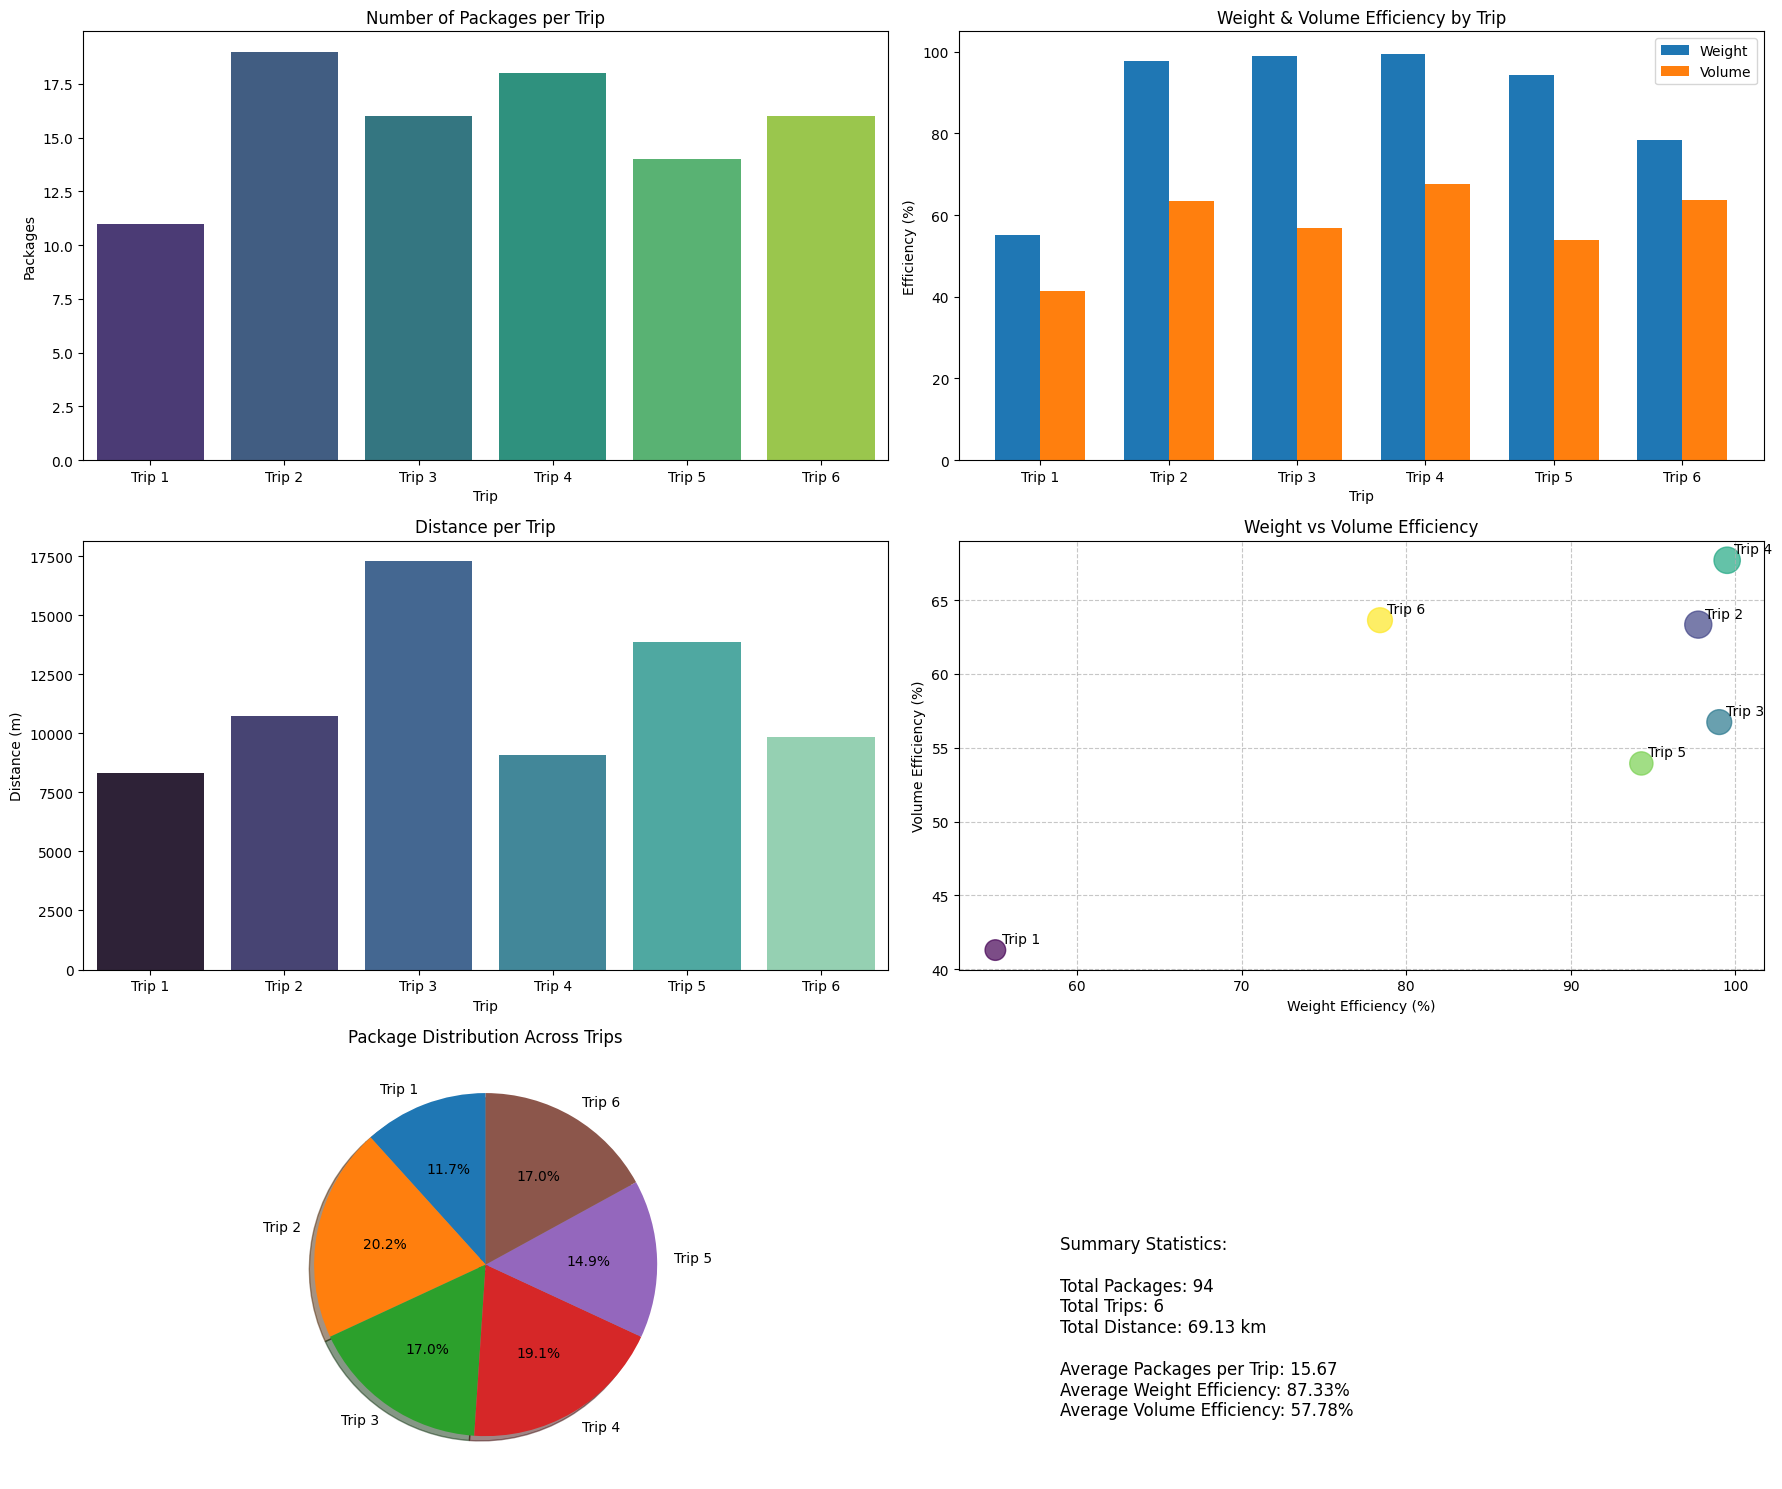


=== Algorithm Comparison Chart ===


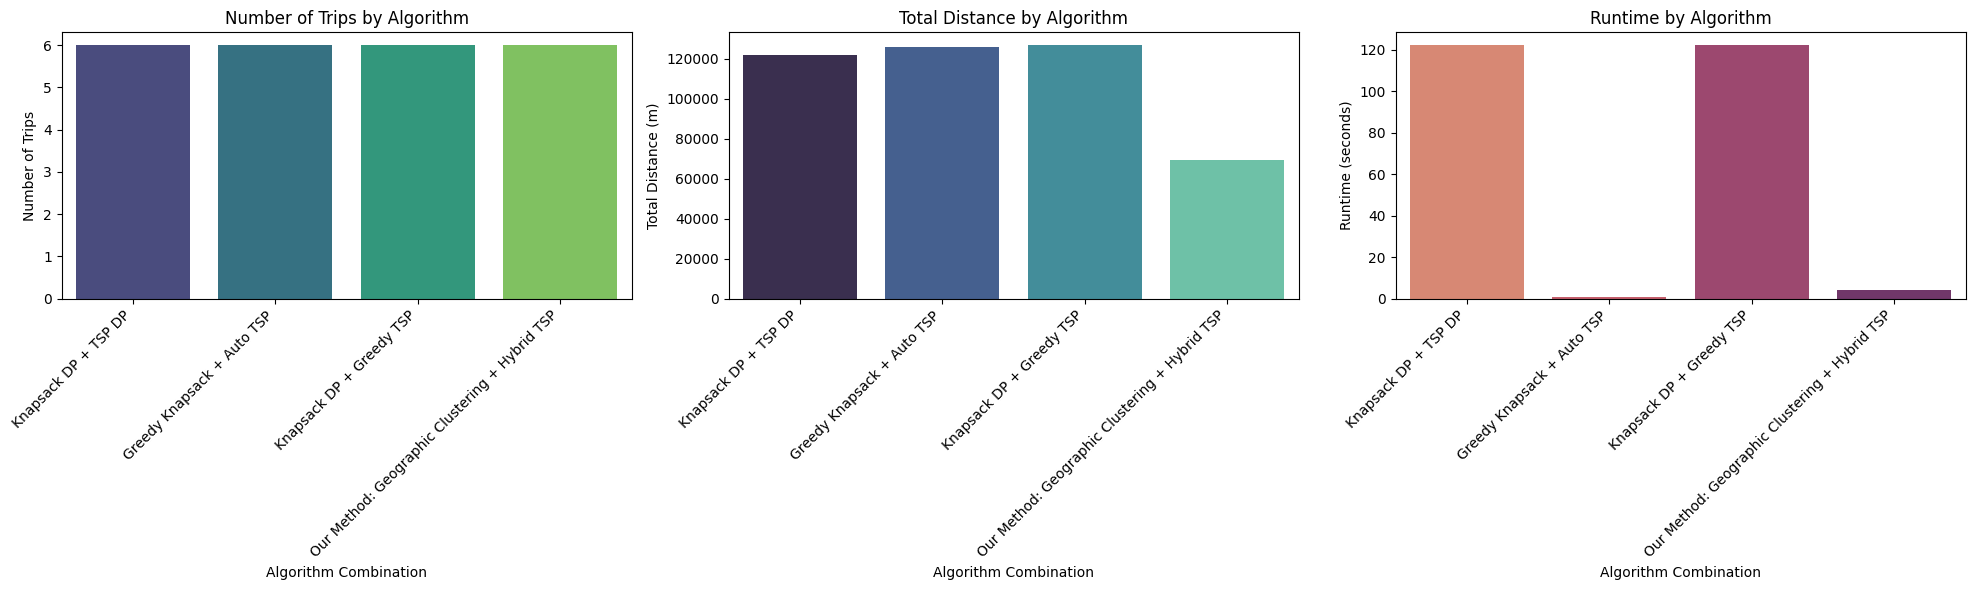


=== Constraint Analysis Visualization ===


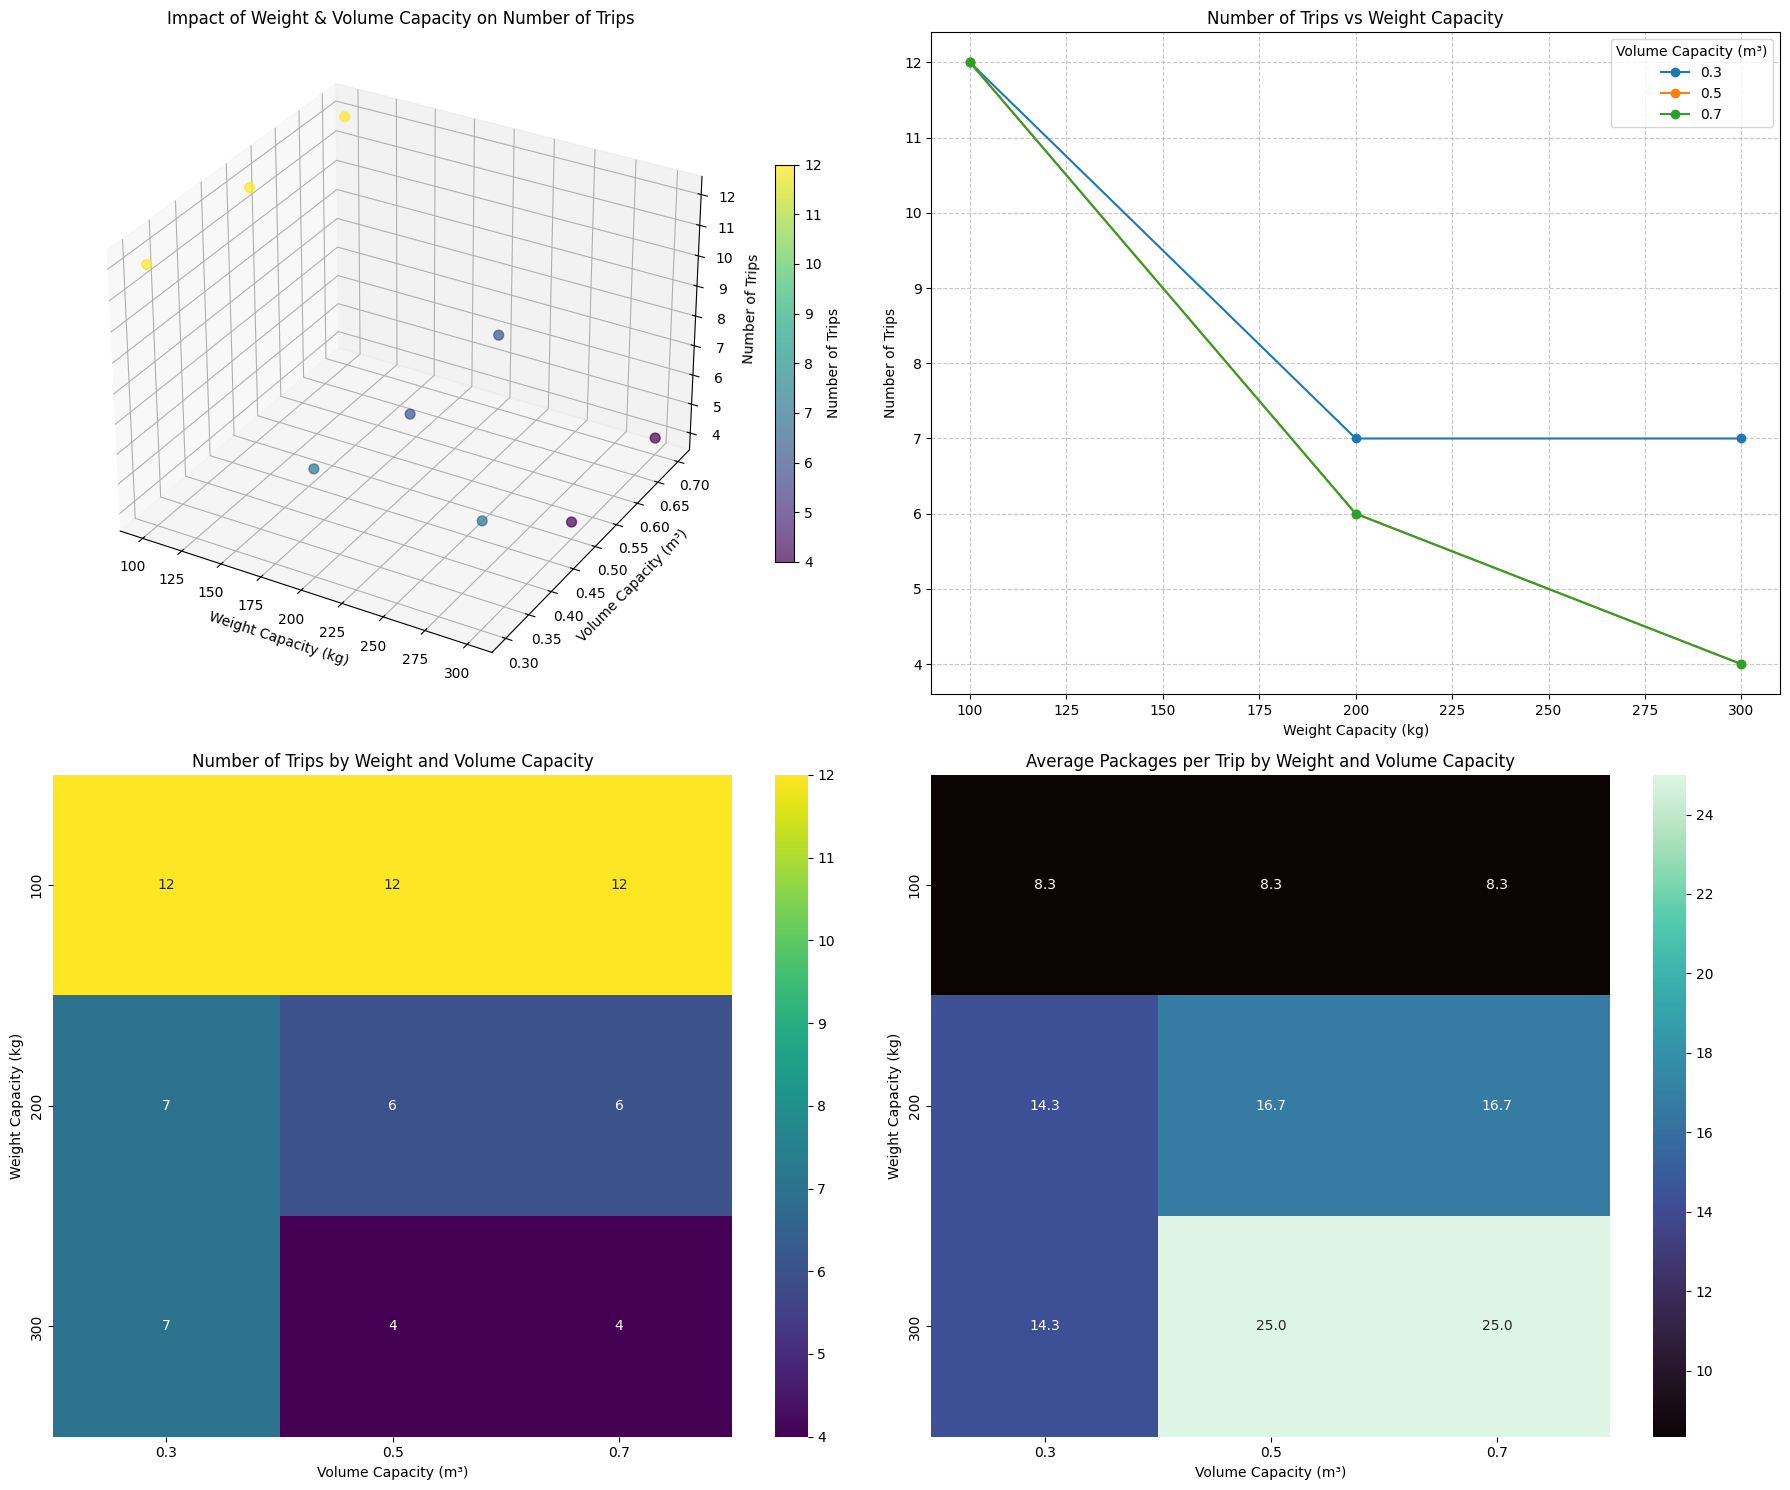


=== Algorithm Efficiency Radar ===


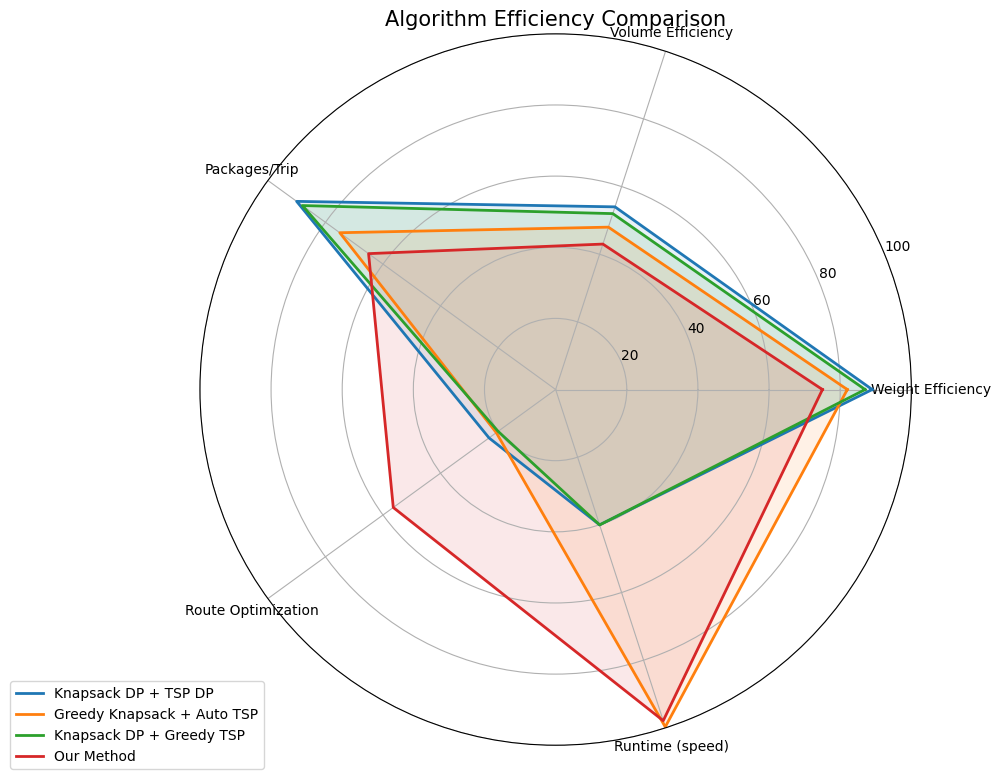

In [ ]:
def run_experiments(results):
    """
    Run all experiments using results from main()
    """
    # 提取所需变量
    packages_df = results['packages_df']
    dist_matrix = results['dist_matrix']
    locations = results['locations']
    depot_node = results['depot_node']
    depot_node_index = locations.index(depot_node)
    weight_capacity = 200  # Same as in main()
    volume_capacity = 0.5  # Same as in main()

    # 运行算法比较
    print("Running algorithm comparison experiment...")
    algorithm_comparison = run_algorithm_comparison(
        packages_df, dist_matrix, locations, depot_node_index,
        weight_capacity, volume_capacity
    )
    display(algorithm_comparison)

    # 运行约束比较
    print("\nRunning constraint comparison experiment...")
    constraint_comparison = run_constraint_comparison(
        packages_df, dist_matrix, locations, depot_node_index
    )
    display(constraint_comparison)

    return {
        'algorithm_comparison': algorithm_comparison,
        'constraint_comparison': constraint_comparison
    }

results = main()
experiment_results = run_experiments(results)
create_all_visualizations(results, experiment_results)

## 10. Multi-Vehicle Extension

=== Multi-Vehicle Package Delivery Optimization System ===

Successfully downloaded road network with 1906 nodes and 2775 edges
Generating 100 synthetic packages...
Successfully generated 100 packages
Depot location: Node ID=61329105, Coordinates=(42.372238, -71.097658)
Building distance matrix...
Distance matrix built successfully

Fleet information:
Number of vehicles: 3
Weight capacity per vehicle: 200 kg
Volume capacity per vehicle: 0.5 m³

--- Single-Vehicle Scheduling (for comparison) ---

⚠️ Packages exceed max for dp(15): Use greedy tsp
Running nearest neighbor TSP with 16 packages
Running knapsack algorithm to optimize loading...
📦 Package 0 example — Weight: 198, Volume: 16
🚛 Knapsack capacity in DP units — W: 2000, V: 500
Knapsack algorithm selected 20 packages
Total weight: 199.20 kg / 200 kg
Total volume: 0.2310 m³ / 0.5 m³

⚠️ Packages exceed max for dp(15): Use greedy tsp
Running nearest neighbor TSP with 20 packages

⚠️ Packages exceed max for dp(15): Use greedy tsp
Run

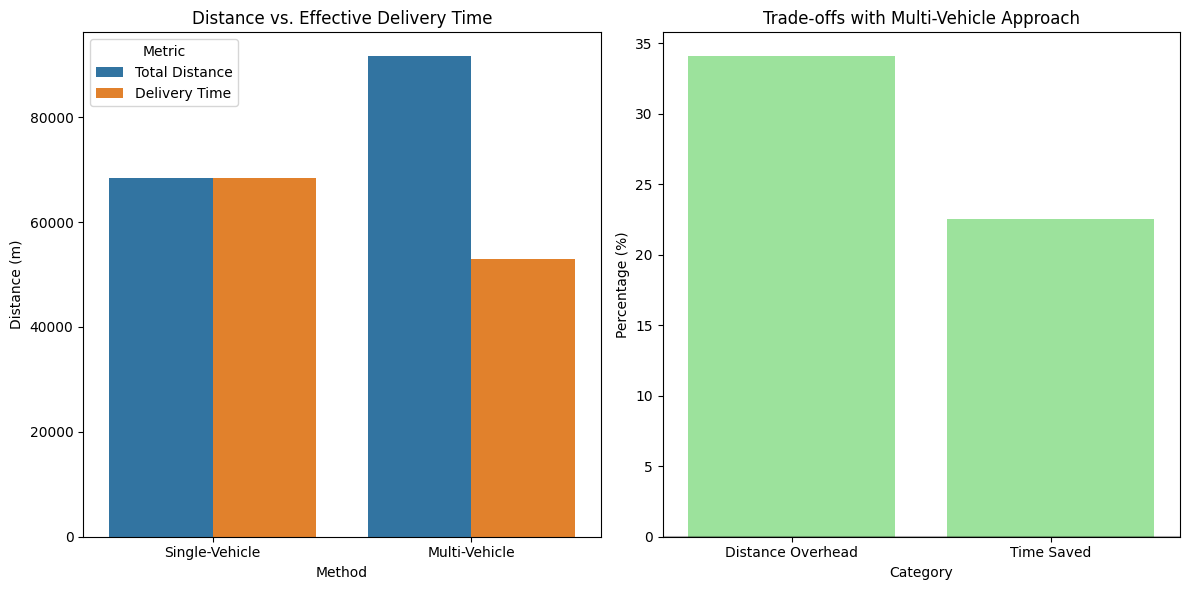

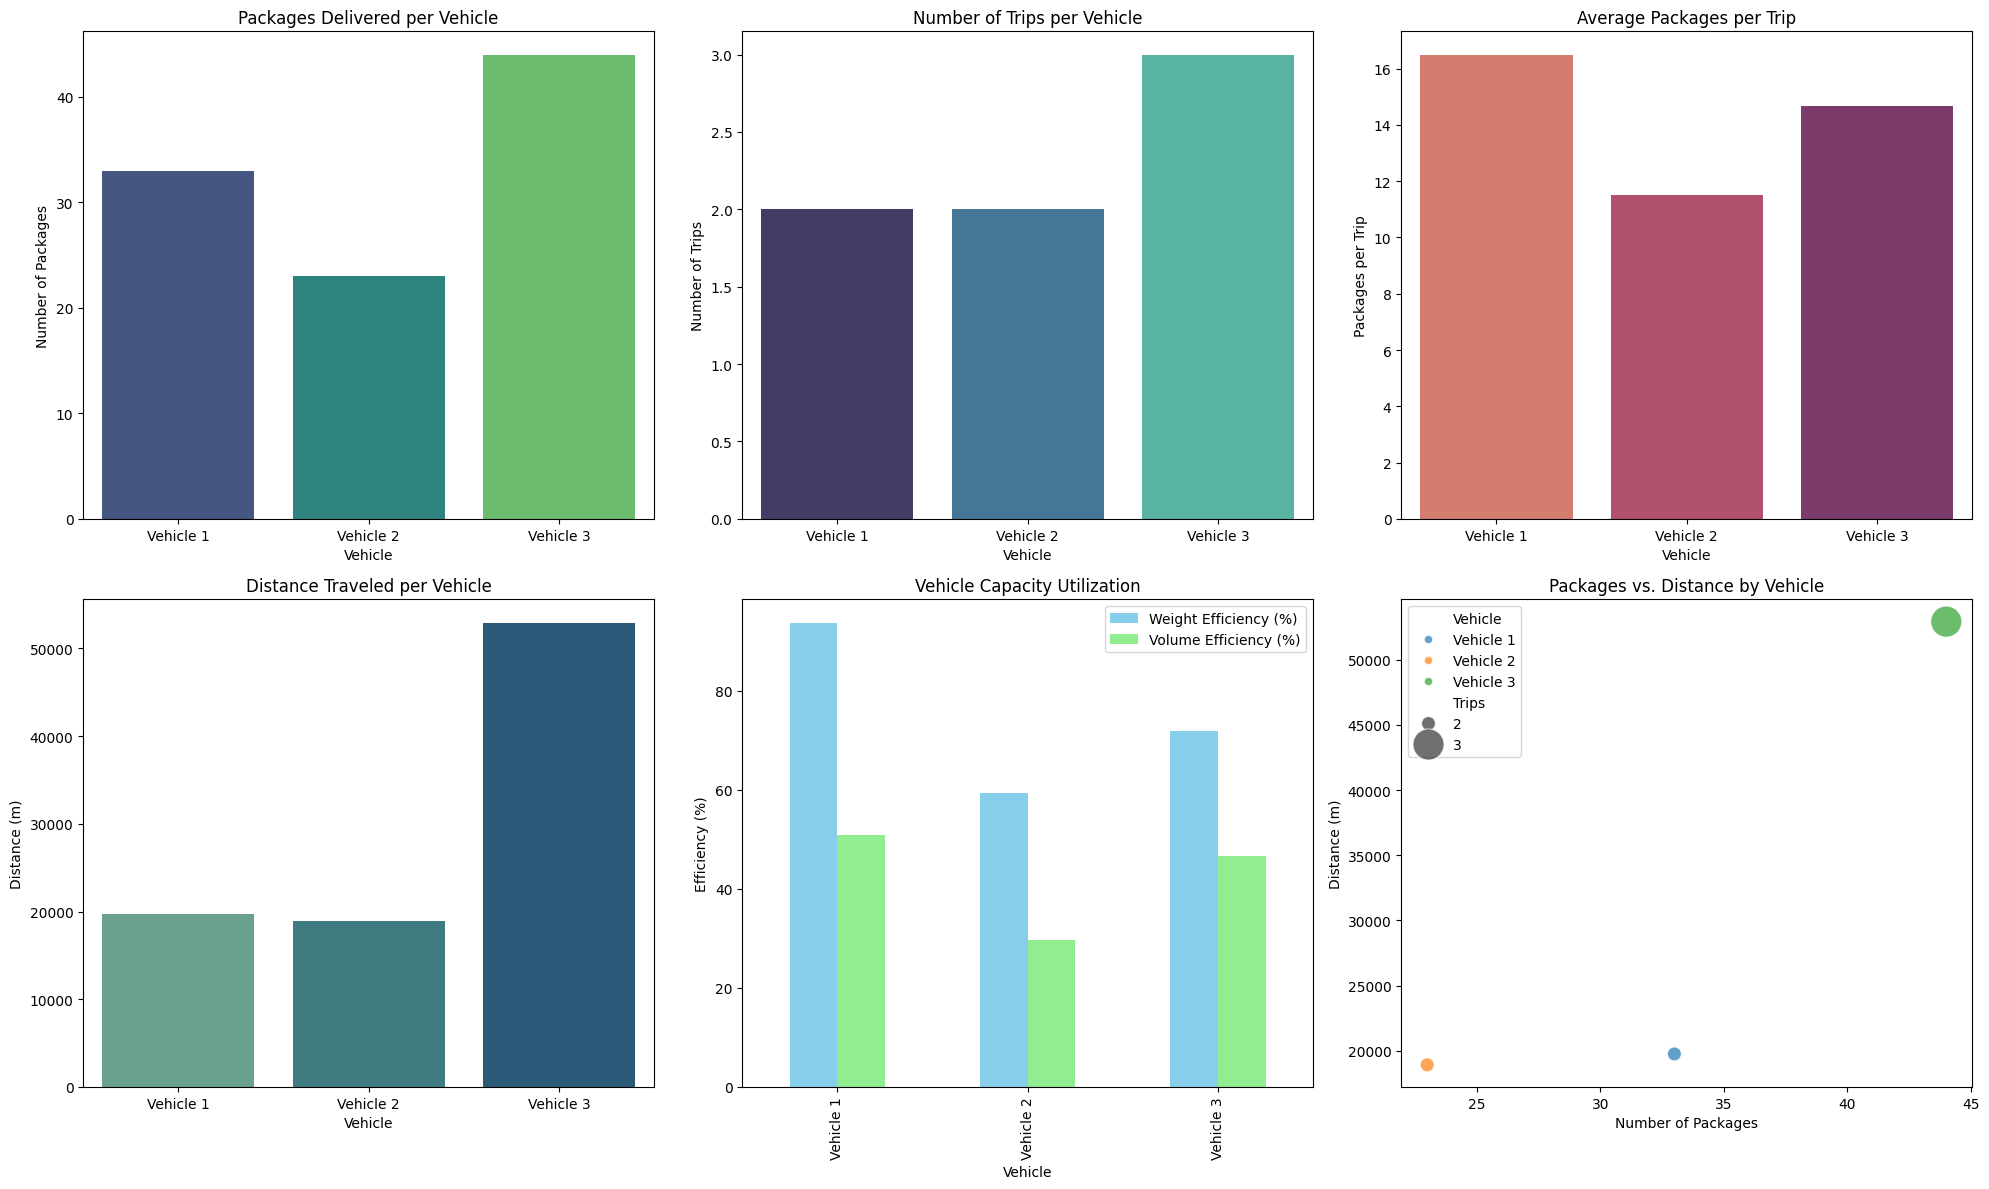


=== Multi-Vehicle Delivery Optimization Complete ===


,Vehicle,Trips,Packages,Distance (m),Avg. Packages/Trip,Weight Efficiency (%),Volume Efficiency (%)
0,Vehicle 1,2,33,19751.543063,16.500000,93.800000,50.9
1,Vehicle 2,2,23,18918.998057,11.500000,59.300000,29.6
2,Vehicle 3,3,44,52923.111863,14.666667,71.916667,46.6


,Metric,Single-Vehicle,Multi-Vehicle
0,Total Travel Distance (m),68308.970552,91593.652984
1,Effective Delivery Time (m),68308.970552,52923.111863
2,Number of Vehicles,1.000000,3.000000
3,Time Savings (%),0.000000,22.523921


In [ ]:
"""## 10. Multi-Vehicle Extension
This section extends the package delivery system to support multiple vehicles,
allowing parallel delivery to optimize total delivery time.
"""

def multi_vehicle_scheduling(packages_df, dist_matrix, locations, depot_node_index,
                             weight_capacity, volume_capacity, num_vehicles=3):
    """
    Schedule deliveries across multiple vehicles with load balancing.

    Args:
        packages_df (pd.DataFrame): Package information
        dist_matrix (np.ndarray): Distance matrix between all locations
        locations (list): Node IDs corresponding to matrix indices
        depot_node_index (int): Index of depot in dist_matrix
        weight_capacity (float): Weight capacity per vehicle
        volume_capacity (float): Volume capacity per vehicle
        num_vehicles (int): Number of vehicles in the fleet

    Returns:
        dict: Vehicle assignments and routing information
    """
    from sklearn.cluster import KMeans
    import numpy as np

    print(f"🚚 Starting multi-vehicle scheduling with {num_vehicles} vehicles...")

    # Extract geographic coordinates for clustering
    coords = np.array([(pkg['Destination_Lat'], pkg['Destination_Lon'])
                       for _, pkg in packages_df.iterrows()])

    # Use K-means to partition deliveries into geographic clusters
    kmeans = KMeans(n_clusters=num_vehicles, random_state=42).fit(coords)
    packages_df_copy = packages_df.copy()
    packages_df_copy['vehicle_cluster'] = kmeans.labels_

    # Initialize data structures for each vehicle
    vehicles = []
    for v in range(num_vehicles):
        vehicles.append({
            'id': v + 1,
            'trips': [],
            'total_distance': 0,
            'max_trip_distance': 0,
            'total_packages': 0
        })

    # Process each vehicle cluster
    for vehicle_id in range(num_vehicles):
        print(f"\n🚗 Planning for Vehicle #{vehicle_id + 1}...")

        # Get packages assigned to this vehicle
        vehicle_packages = packages_df_copy[packages_df_copy['vehicle_cluster'] == vehicle_id]
        if vehicle_packages.empty:
            print(f"  ⚠️ No packages assigned to Vehicle #{vehicle_id + 1}")
            continue

        print(f"  📦 {len(vehicle_packages)} packages assigned")

        # Check if vehicle needs multiple trips
        vehicle_weight = vehicle_packages['Weight'].sum()
        vehicle_volume = vehicle_packages['Volume'].sum()

        # Get original indices for later reference
        available_packages = vehicle_packages.index.tolist()

        # Schedule multiple trips if needed
        trip_num = 1
        while available_packages:
            print(f"  Planning trip #{trip_num} for Vehicle #{vehicle_id + 1}...")

            # Create dataframe with remaining packages for this vehicle
            trip_df = packages_df.iloc[available_packages].reset_index(drop=True)

            # Use knapsack to optimize loading for this trip
            # Map local indices back to original indices
            trip_df['original_index'] = trip_df.index.map(lambda i: available_packages[i])
            selected_indices, trip_weight, trip_volume = knapsack_dp(
                trip_df, weight_capacity, volume_capacity
            )

            if not selected_indices:
                print(f"  ⚠️ No packages selected for Vehicle #{vehicle_id + 1}, Trip #{trip_num}")
                break

            # Map selected indices back to original dataframe indices
            selected_original_indices = [available_packages[i] for i in selected_indices]

            # Get matrix indices for TSP
            package_matrix_indices = []
            for pkg_idx in selected_original_indices:
                dest_node_id = packages_df.loc[pkg_idx]['Destination_Node']
                try:
                    matrix_idx = locations.index(dest_node_id)
                    package_matrix_indices.append(matrix_idx)
                except ValueError:
                    print(f"  ⚠️ Node ID {dest_node_id} not found in locations list. Skipping.")

            if not package_matrix_indices:
                print(f"  ⚠️ No valid destinations for Vehicle #{vehicle_id + 1}, Trip #{trip_num}")
                break

            # Run TSP with appropriate method based on problem size
            if len(package_matrix_indices) <= 15:
                route_matrix_indices, trip_distance = tsp_dp(
                    dist_matrix, package_matrix_indices, depot_node_index
                )
            else:
                print(f"  ⚠️ {len(package_matrix_indices)} packages — using greedy TSP instead.")
                route_matrix_indices, trip_distance = tsp_nearest_neighbor(
                    dist_matrix, package_matrix_indices, depot_node_index
                )

            # Map route indices back to actual graph node IDs
            route_node_ids = [locations[i] for i in route_matrix_indices]

            # Record this trip
            vehicles[vehicle_id]['trips'].append({
                'route': route_node_ids,
                'package_indices': selected_original_indices,
                'distance': trip_distance,
                'weight': trip_weight,
                'volume': trip_volume,
                'trip_num': trip_num
            })

            # Update vehicle stats
            vehicles[vehicle_id]['total_distance'] += trip_distance
            vehicles[vehicle_id]['max_trip_distance'] = max(
                vehicles[vehicle_id]['max_trip_distance'], trip_distance
            )
            vehicles[vehicle_id]['total_packages'] += len(selected_original_indices)

            # Remove processed packages
            for idx in selected_original_indices:
                available_packages.remove(idx)

            print(f"  ✅ Vehicle #{vehicle_id + 1}, Trip #{trip_num}: {len(selected_original_indices)} packages, "
                  f"distance: {trip_distance:.2f} m")
            trip_num += 1

    # Calculate overall metrics
    total_distance = sum(v['total_distance'] for v in vehicles)
    total_packages = sum(v['total_packages'] for v in vehicles)
    max_vehicle_time = max(v['total_distance'] for v in vehicles)

    # Calculate time savings compared to serial delivery
    time_savings_percent = ((total_distance - max_vehicle_time) / total_distance) * 100 if total_distance > 0 else 0

    # Summarize results
    print("\n=== Multi-Vehicle Scheduling Summary ===")
    print(f"Total packages delivered: {total_packages}")
    print(f"Total distance across all vehicles: {total_distance:.2f} m")
    print(f"Max distance for any vehicle: {max_vehicle_time:.2f} m")
    print(f"Estimated time savings vs. serial delivery: {time_savings_percent:.2f}%")

    return {
        'vehicles': vehicles,
        'total_distance': total_distance,
        'max_vehicle_time': max_vehicle_time,
        'time_savings_percent': time_savings_percent
    }

def shared_pool_multi_vehicle_scheduling(packages_df, dist_matrix, locations, depot_node_index,
                                         weight_capacity, volume_capacity, num_vehicles=3):
    """
    Multi-vehicle scheduling using a shared package pool (no clustering).

    Args:
        packages_df (pd.DataFrame): Package info
        dist_matrix (np.ndarray): Precomputed distance matrix
        locations (List[int]): List of graph node IDs matching matrix
        depot_node_index (int): Index of depot in dist_matrix
        weight_capacity (float): Vehicle weight limit
        volume_capacity (float): Vehicle volume limit
        num_vehicles (int): Number of vehicles to dispatch

    Returns:
        dict: All vehicle trip info and performance metrics
    """
    print(f"🚚 Shared-pool multi-vehicle scheduling with {num_vehicles} vehicles...")
    import numpy as np

    # Initialize shared pool of available package indices
    available_packages = list(range(len(packages_df)))

    # Initialize vehicles
    vehicles = [{
        'id': v + 1,
        'trips': [],
        'total_distance': 0,
        'max_trip_distance': 0,
        'total_packages': 0
    } for v in range(num_vehicles)]

    trip_round = 0
    while available_packages:
        for vehicle in vehicles:
            if not available_packages:
                break

            trip_round += 1
            print(f"\n🚗 Vehicle #{vehicle['id']} planning trip #{len(vehicle['trips']) + 1}")

            # Create DataFrame from remaining packages
            trip_df = packages_df.iloc[available_packages].reset_index(drop=True)

            # Run knapsack to pick optimal subset
            selected_indices, trip_weight, trip_volume = knapsack_dp(
                trip_df, weight_capacity, volume_capacity
            )

            if not selected_indices:
                print(f"⚠️ No packages selected for Vehicle #{vehicle['id']} in this round.")
                continue

            selected_global_indices = [available_packages[i] for i in selected_indices]

            # Convert package indices to dist_matrix indices
            package_matrix_indices = []
            for pkg_idx in selected_global_indices:
                dest_node = packages_df.loc[pkg_idx]['Destination_Node']
                try:
                    matrix_idx = locations.index(dest_node)
                    package_matrix_indices.append(matrix_idx)
                except ValueError:
                    print(f"⚠️ Node {dest_node} not found in locations. Skipping.")

            if not package_matrix_indices:
                continue

            # TSP strategy
            if len(package_matrix_indices) <= 15:
                route_matrix_indices, trip_distance = tsp_dp(
                    dist_matrix, package_matrix_indices, depot_node_index
                )
            else:
                route_matrix_indices, trip_distance = tsp_nearest_neighbor(
                    dist_matrix, package_matrix_indices, depot_node_index
                )

            # Convert route indices to graph node IDs
            route_node_ids = [locations[i] for i in route_matrix_indices]

            # Record trip
            trip_info = {
                'route': route_node_ids,
                'package_indices': selected_global_indices,
                'distance': trip_distance,
                'weight': trip_weight,
                'volume': trip_volume,
                'trip_num': len(vehicle['trips']) + 1
            }

            vehicle['trips'].append(trip_info)
            vehicle['total_distance'] += trip_distance
            vehicle['max_trip_distance'] = max(vehicle['max_trip_distance'], trip_distance)
            vehicle['total_packages'] += len(selected_global_indices)

            # Remove delivered packages from pool
            for idx in selected_global_indices:
                available_packages.remove(idx)

            print(f"✅ Vehicle #{vehicle['id']} Trip #{trip_info['trip_num']}: {len(selected_global_indices)} packages, {trip_distance:.2f} m")

    # Final metrics
    total_distance = sum(v['total_distance'] for v in vehicles)
    max_vehicle_time = max(v['total_distance'] for v in vehicles)
    total_packages = sum(v['total_packages'] for v in vehicles)
    time_savings = (total_distance - max_vehicle_time) / total_distance * 100 if total_distance > 0 else 0

    print("\n=== Shared-Pool Multi-Vehicle Summary ===")
    print(f"Total packages: {total_packages}")
    print(f"Total distance: {total_distance:.2f} m")
    print(f"Max distance (parallel delivery time): {max_vehicle_time:.2f} m")
    print(f"Time savings vs. serial delivery: {time_savings:.2f}%")

    return {
        'vehicles': vehicles,
        'total_distance': total_distance,
        'max_vehicle_time': max_vehicle_time,
        'time_savings_percent': time_savings
    }


def visualize_multi_vehicle_routes(G, packages_df, vehicles_data, locations, depot_node):
    """
    Visualize delivery routes for multiple vehicles, with each vehicle using a distinct color.

    Args:
        G (networkx.MultiDiGraph): Road network graph
        packages_df (pd.DataFrame): Package information
        vehicles_data (dict): Output from multi_vehicle_scheduling
        locations (list): Node IDs corresponding to matrix indices
        depot_node (int): Node ID of the depot

    Returns:
        folium.Map: Map with visualized routes
    """
    import folium
    import networkx as nx
    from folium.plugins import MarkerCluster

    print("Generating multi-vehicle delivery route visualization...")

    vehicles = vehicles_data['vehicles']
    depot_coords = (G.nodes[depot_node]['lat'], G.nodes[depot_node]['lon'])

    # Collect all delivery coordinates + depot for fitting bounds
    all_coords = []
    for vehicle in vehicles:
        for trip in vehicle['trips']:
            for pkg_idx in trip['package_indices']:
                all_coords.append((
                    packages_df.loc[pkg_idx]['Destination_Lat'],
                    packages_df.loc[pkg_idx]['Destination_Lon']
                ))
    all_coords.append(depot_coords)

    # Create map and fit bounds
    bounds = [
        [min(lat for lat, _ in all_coords), min(lon for _, lon in all_coords)],
        [max(lat for lat, _ in all_coords), max(lon for _, lon in all_coords)]
    ]

    m = folium.Map(location=depot_coords, zoom_start=14)
    m.fit_bounds(bounds)

    # Add depot marker
    folium.Marker(
        location=depot_coords,
        popup="Depot",
        icon=folium.Icon(color='red', icon='warehouse', prefix='fa')
    ).add_to(m)

    # Define vehicle colors - more distinct colors for better visualization
    vehicle_colors = ['blue', 'green', 'purple', 'orange', 'darkred', 'cadetblue',
                     'darkpurple', 'pink', 'darkblue', 'darkgreen', 'gray', 'black']

    # Create marker clusters for each vehicle
    vehicle_clusters = {}
    for v_idx, vehicle in enumerate(vehicles):
        vehicle_id = vehicle['id']
        vehicle_clusters[vehicle_id] = MarkerCluster(name=f"Vehicle {vehicle_id}").add_to(m)

    # Process each vehicle's trips
    for v_idx, vehicle in enumerate(vehicles):
        vehicle_id = vehicle['id']
        vehicle_color = vehicle_colors[v_idx % len(vehicle_colors)]

        # Process each trip for this vehicle
        for trip in vehicle['trips']:
            trip_num = trip['trip_num']
            route = trip['route']

            # Add package markers for this trip
            for pkg_idx in trip['package_indices']:
                pkg = packages_df.loc[pkg_idx]
                coords = (pkg['Destination_Lat'], pkg['Destination_Lon'])

                folium.Marker(
                    location=coords,
                    popup=f"Vehicle {vehicle_id}, Trip {trip_num}<br>"
                          f"Package ID: {pkg['Package_ID']}<br>"
                          f"Weight: {pkg['Weight']} kg<br>"
                          f"Volume: {pkg['Volume']} m³",
                    icon=folium.Icon(color=vehicle_color, icon='cube', prefix='fa')
                ).add_to(vehicle_clusters[vehicle_id])

            # Draw the route (shortest paths between consecutive points)
            for i in range(len(route) - 1):
                node_u = route[i]
                node_v = route[i + 1]

                try:
                    path = nx.shortest_path(G, node_u, node_v, weight='weight')
                    path_coords = [(G.nodes[n]['lat'], G.nodes[n]['lon']) for n in path]

                    # Use dashed line for trips after the first one
                    line_dash = 'dashed' if trip_num > 1 else None

                    folium.PolyLine(
                        locations=path_coords,
                        color=vehicle_color,
                        weight=4,
                        opacity=0.8,
                        popup=f"Vehicle {vehicle_id}, Trip {trip_num}: Segment {i+1}",
                        dash_array='5, 10' if line_dash else None
                    ).add_to(m)

                except nx.NetworkXNoPath:
                    print(f"⚠️ No path between Node {node_u} and {node_v}")
                except Exception as e:
                    print(f"⚠️ Error drawing path from {node_u} to {node_v}: {e}")

    # Add layer control for toggling vehicle visibility
    folium.LayerControl().add_to(m)

    return m

def analyze_multi_vehicle_performance(vehicles_data, packages_df, weight_capacity, volume_capacity):
    """
    Analyze performance metrics for multi-vehicle scheduling.

    Args:
        vehicles_data (dict): Output from multi_vehicle_scheduling
        packages_df (pd.DataFrame): Package information
        weight_capacity (float): Weight capacity per vehicle
        volume_capacity (float): Volume capacity per vehicle

    Returns:
        pd.DataFrame: Performance metrics by vehicle
    """
    import pandas as pd

    print("\n=== Multi-Vehicle Performance Analysis ===")

    vehicles = vehicles_data['vehicles']
    vehicle_metrics = []

    # Analyze each vehicle
    for vehicle in vehicles:
        vehicle_id = vehicle['id']

        if not vehicle['trips']:
            print(f"Vehicle #{vehicle_id}: No trips assigned")
            continue

        total_trips = len(vehicle['trips'])
        total_packages = vehicle['total_packages']
        total_distance = vehicle['total_distance']

        # Calculate vehicle efficiency metrics
        vehicle_weight_load = sum(
            trip['weight'] for trip in vehicle['trips']
        )
        vehicle_volume_load = sum(
            trip['volume'] for trip in vehicle['trips']
        )

        # Calculate efficiency percentages over all trips combined
        max_possible_weight = weight_capacity * total_trips
        max_possible_volume = volume_capacity * total_trips
        weight_efficiency = (vehicle_weight_load / max_possible_weight * 100) if max_possible_weight > 0 else 0
        volume_efficiency = (vehicle_volume_load / max_possible_volume * 100) if max_possible_volume > 0 else 0

        # Record metrics
        vehicle_metrics.append({
            'Vehicle': f"Vehicle {vehicle_id}",
            'Trips': total_trips,
            'Packages': total_packages,
            'Distance (m)': total_distance,
            'Avg. Packages/Trip': total_packages / total_trips if total_trips > 0 else 0,
            'Weight Efficiency (%)': weight_efficiency,
            'Volume Efficiency (%)': volume_efficiency
        })

        # Print detailed trip information
        print(f"\nVehicle #{vehicle_id}:")
        print(f"  Trips: {total_trips}")
        print(f"  Packages: {total_packages}")
        print(f"  Total distance: {total_distance:.2f} m")
        print(f"  Weight efficiency: {weight_efficiency:.2f}%")
        print(f"  Volume efficiency: {volume_efficiency:.2f}%")

        # Print trip-by-trip details
        for i, trip in enumerate(vehicle['trips']):
            print(f"  Trip #{i+1}:")
            print(f"    Packages: {len(trip['package_indices'])}")
            print(f"    Distance: {trip['distance']:.2f} m")
            print(f"    Weight: {trip['weight']:.2f} kg ({(trip['weight'] / weight_capacity * 100):.2f}%)")
            print(f"    Volume: {trip['volume']:.4f} m³ ({(trip['volume'] / volume_capacity * 100):.2f}%)")

    # Create DataFrame for easy visualization
    vehicle_df = pd.DataFrame(vehicle_metrics)

    # Calculate summary stats
    total_packages = sum(v['Packages'] for v in vehicle_metrics)
    total_trips = sum(v['Trips'] for v in vehicle_metrics)
    total_distance = sum(v['Distance (m)'] for v in vehicle_metrics)
    max_vehicle_time = max(v['Distance (m)'] for v in vehicle_metrics) if vehicle_metrics else 0

    # Calculate time savings (assuming proportional to distance)
    time_savings = (total_distance - max_vehicle_time) / total_distance * 100 if total_distance > 0 else 0

    print("\n=== Multi-Vehicle Summary ===")
    print(f"Total packages: {total_packages}")
    print(f"Total trips: {total_trips}")
    print(f"Total distance across all vehicles: {total_distance:.2f} m")
    print(f"Max distance for any vehicle (delivery time): {max_vehicle_time:.2f} m")
    print(f"Time savings vs. serial delivery: {time_savings:.2f}%")

    return vehicle_df

def compare_single_vs_multi_vehicle(single_vehicle_results, multi_vehicle_results):
    """
    Compare single-vehicle and multi-vehicle scheduling approaches.

    Args:
        single_vehicle_results (dict): Results from single-vehicle scheduling
        multi_vehicle_results (dict): Results from multi-vehicle scheduling

    Returns:
        pd.DataFrame: Comparison metrics
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    print("\n=== Single vs. Multi-Vehicle Comparison ===")

    # Extract key metrics
    single_total_distance = single_vehicle_results['total_distance']
    multi_total_distance = multi_vehicle_results['total_distance']
    max_vehicle_time = multi_vehicle_results['max_vehicle_time']

    # Calculate improvement percentages
    distance_increase = (multi_total_distance / single_total_distance - 1) * 100
    time_savings = (single_total_distance - max_vehicle_time) / single_total_distance * 100

    # Create comparison DataFrame
    comparison = pd.DataFrame({
        'Metric': [
            'Total Travel Distance (m)',
            'Effective Delivery Time (m)',
            'Number of Vehicles',
            'Time Savings (%)'
        ],
        'Single-Vehicle': [
            single_total_distance,
            single_total_distance,
            1,
            0
        ],
        'Multi-Vehicle': [
            multi_total_distance,
            max_vehicle_time,
            len([v for v in multi_vehicle_results['vehicles'] if v['trips']]),
            time_savings
        ]
    })

    # Print key findings
    print(f"Single-vehicle total distance: {single_total_distance:.2f} m")
    print(f"Multi-vehicle total distance: {multi_total_distance:.2f} m")
    print(f"Multi-vehicle max time (critical path): {max_vehicle_time:.2f} m")
    print(f"Distance overhead with multiple vehicles: {distance_increase:.2f}%")
    print(f"Time savings with multiple vehicles: {time_savings:.2f}%")

    # Create visualization
    plt.figure(figsize=(12, 6))

    # Distance and time comparison
    ax1 = plt.subplot(1, 2, 1)
    data = pd.DataFrame({
        'Method': ['Single-Vehicle', 'Single-Vehicle', 'Multi-Vehicle', 'Multi-Vehicle'],
        'Metric': ['Total Distance', 'Delivery Time', 'Total Distance', 'Delivery Time'],
        'Value': [
            single_total_distance,
            single_total_distance,
            multi_total_distance,
            max_vehicle_time
        ]
    })

    sns.barplot(x='Method', y='Value', hue='Metric', data=data, ax=ax1)
    ax1.set_ylabel('Distance (m)')
    ax1.set_title('Distance vs. Effective Delivery Time')

    # Delivery time reduction
    ax2 = plt.subplot(1, 2, 2)
    time_data = pd.DataFrame({
        'Category': ['Distance Overhead', 'Time Saved'],
        'Percentage': [distance_increase, time_savings]
    })

    colors = ['lightcoral' if val < 0 else 'lightgreen' for val in time_data['Percentage']]
    sns.barplot(x='Category', y='Percentage', data=time_data, ax=ax2, palette=colors)
    ax2.set_ylabel('Percentage (%)')
    ax2.set_title('Trade-offs with Multi-Vehicle Approach')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    plt.tight_layout()
    plt.show()

    return comparison

def visualize_multi_vehicle_metrics(vehicle_metrics):
    """
    Create visualizations of multi-vehicle performance metrics.

    Args:
        vehicle_metrics (pd.DataFrame): Performance metrics by vehicle

    Returns:
        matplotlib.figure.Figure: Figure with visualizations
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Create visualization
    fig = plt.figure(figsize=(20, 12))

    # 1. Packages per vehicle
    ax1 = fig.add_subplot(2, 3, 1)
    sns.barplot(x='Vehicle', y='Packages', data=vehicle_metrics, ax=ax1, palette='viridis')
    ax1.set_title('Packages Delivered per Vehicle')
    ax1.set_ylabel('Number of Packages')

    # 2. Trips per vehicle
    ax2 = fig.add_subplot(2, 3, 2)
    sns.barplot(x='Vehicle', y='Trips', data=vehicle_metrics, ax=ax2, palette='mako')
    ax2.set_title('Number of Trips per Vehicle')
    ax2.set_ylabel('Number of Trips')

    # 3. Average packages per trip
    ax3 = fig.add_subplot(2, 3, 3)
    sns.barplot(x='Vehicle', y='Avg. Packages/Trip', data=vehicle_metrics, ax=ax3, palette='flare')
    ax3.set_title('Average Packages per Trip')
    ax3.set_ylabel('Packages per Trip')

    # 4. Distance per vehicle
    ax4 = fig.add_subplot(2, 3, 4)
    sns.barplot(x='Vehicle', y='Distance (m)', data=vehicle_metrics, ax=ax4, palette='crest')
    ax4.set_title('Distance Traveled per Vehicle')
    ax4.set_ylabel('Distance (m)')

    # 5. Weight and volume efficiency
    ax5 = fig.add_subplot(2, 3, 5)
    vehicle_metrics.plot(
        x='Vehicle',
        y=['Weight Efficiency (%)', 'Volume Efficiency (%)'],
        kind='bar',
        ax=ax5,
        color=['skyblue', 'lightgreen']
    )
    ax5.set_title('Vehicle Capacity Utilization')
    ax5.set_ylabel('Efficiency (%)')
    ax5.legend(loc='upper right')

    # 6. Scatter plot of packages vs. distance
    ax6 = fig.add_subplot(2, 3, 6)
    sns.scatterplot(
        x='Packages',
        y='Distance (m)',
        size='Trips',
        hue='Vehicle',
        sizes=(100, 500),
        alpha=0.7,
        data=vehicle_metrics,
        ax=ax6
    )
    ax6.set_title('Packages vs. Distance by Vehicle')
    ax6.set_xlabel('Number of Packages')
    ax6.set_ylabel('Distance (m)')

    plt.tight_layout()
    plt.show()

    return fig

def main_multi_vehicle(num_vehicles=3):
    """
    Main function to run the multi-vehicle package delivery optimization system.

    Args:
        num_vehicles (int): Number of vehicles in the fleet

    Returns:
        dict: Results of the optimization
    """
    print("=== Multi-Vehicle Package Delivery Optimization System ===\n")

    # 1. Get road network data (reuse from existing code)
    place_name = "Cambridge, Massachusetts, USA"
    G, gdf_nodes, gdf_edges = get_road_network(place_name)

    # 2. Generate synthetic package data (reuse from existing code)
    num_packages = 100
    packages_df, depot_node = generate_package_data(G, num_packages)

    # 3. Build distance matrix (reuse from existing code)
    dist_matrix, locations = build_distance_matrix(G, packages_df, depot_node)
    depot_node_index = locations.index(depot_node)

    # 4. Set vehicle constraints (same as in existing code)
    weight_capacity = 200  # kg
    volume_capacity = 0.5  # cubic meters

    print(f"\nFleet information:")
    print(f"Number of vehicles: {num_vehicles}")
    print(f"Weight capacity per vehicle: {weight_capacity} kg")
    print(f"Volume capacity per vehicle: {volume_capacity} m³")

    # 5. First run single-vehicle scheduling for comparison
    print("\n--- Single-Vehicle Scheduling (for comparison) ---")
    single_trips, single_total_distance = geographic_clustering_trips(
        packages_df, dist_matrix, locations, depot_node_index,
        weight_capacity, volume_capacity
    )

    # 6. Run multi-vehicle scheduling
    print("\n--- Multi-Vehicle Scheduling ---")
    multi_vehicle_results = multi_vehicle_scheduling(
        packages_df, dist_matrix, locations, depot_node_index,
        weight_capacity, volume_capacity, num_vehicles
    )

    # 7. Visualize multi-vehicle routes
    m_multi_vehicle = visualize_multi_vehicle_routes(
        G, packages_df, multi_vehicle_results, locations, depot_node
    )

    # 8. Analyze multi-vehicle performance
    vehicle_metrics = analyze_multi_vehicle_performance(
        multi_vehicle_results, packages_df, weight_capacity, volume_capacity
    )

    # 9. Compare single vs. multi-vehicle approaches
    single_vehicle_results = {
        'total_distance': single_total_distance,
        'trips': single_trips
    }

    comparison = compare_single_vs_multi_vehicle(
        single_vehicle_results, multi_vehicle_results
    )

    # 10. Visualize multi-vehicle metrics
    visualize_multi_vehicle_metrics(vehicle_metrics)

    return {
        'G': G,
        'packages_df': packages_df,
        'depot_node': depot_node,
        'dist_matrix': dist_matrix,
        'locations': locations,
        'single_vehicle_results': single_vehicle_results,
        'multi_vehicle_results': multi_vehicle_results,
        'map_multi_vehicle': m_multi_vehicle,
        'vehicle_metrics': vehicle_metrics,
        'comparison': comparison
    }

# Run multi-vehicle optimization with 3 vehicles
if __name__ == "__main__":
    # For testing the multi-vehicle implementation
    multi_vehicle_results = main_multi_vehicle(num_vehicles=3)

    # Display results
    print("\n=== Multi-Vehicle Delivery Optimization Complete ===")

    # Display map
    display(multi_vehicle_results['map_multi_vehicle'])

    # Display metrics
    display(multi_vehicle_results['vehicle_metrics'])
    display(multi_vehicle_results['comparison'])